In [ ]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
from statsmodels.tsa.stattools import grangercausalitytests
import itertools

데이터 불러오기 및 확인

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LGaimers/해커톤/train/train.csv')
df.head()

,영업일자,영업장명_메뉴명,매출수량
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102676 entries, 0 to 102675
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   영업일자      102676 non-null  object
 1   영업장명_메뉴명  102676 non-null  object
 2   매출수량      102676 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


In [ ]:
df.describe()

,매출수량
count,102676.000000
mean,10.653083
std,41.887692
min,-80.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,1372.000000


min값이 -80이면 이상치인 가능성 있음(참고: 매출수량에 음수가 존재하므로 반품/취소 데이터가 포함된 것으로 보입니다.)

In [ ]:
df['영업장명_메뉴명'].nunique() #총 메뉴 개수

193

전처리

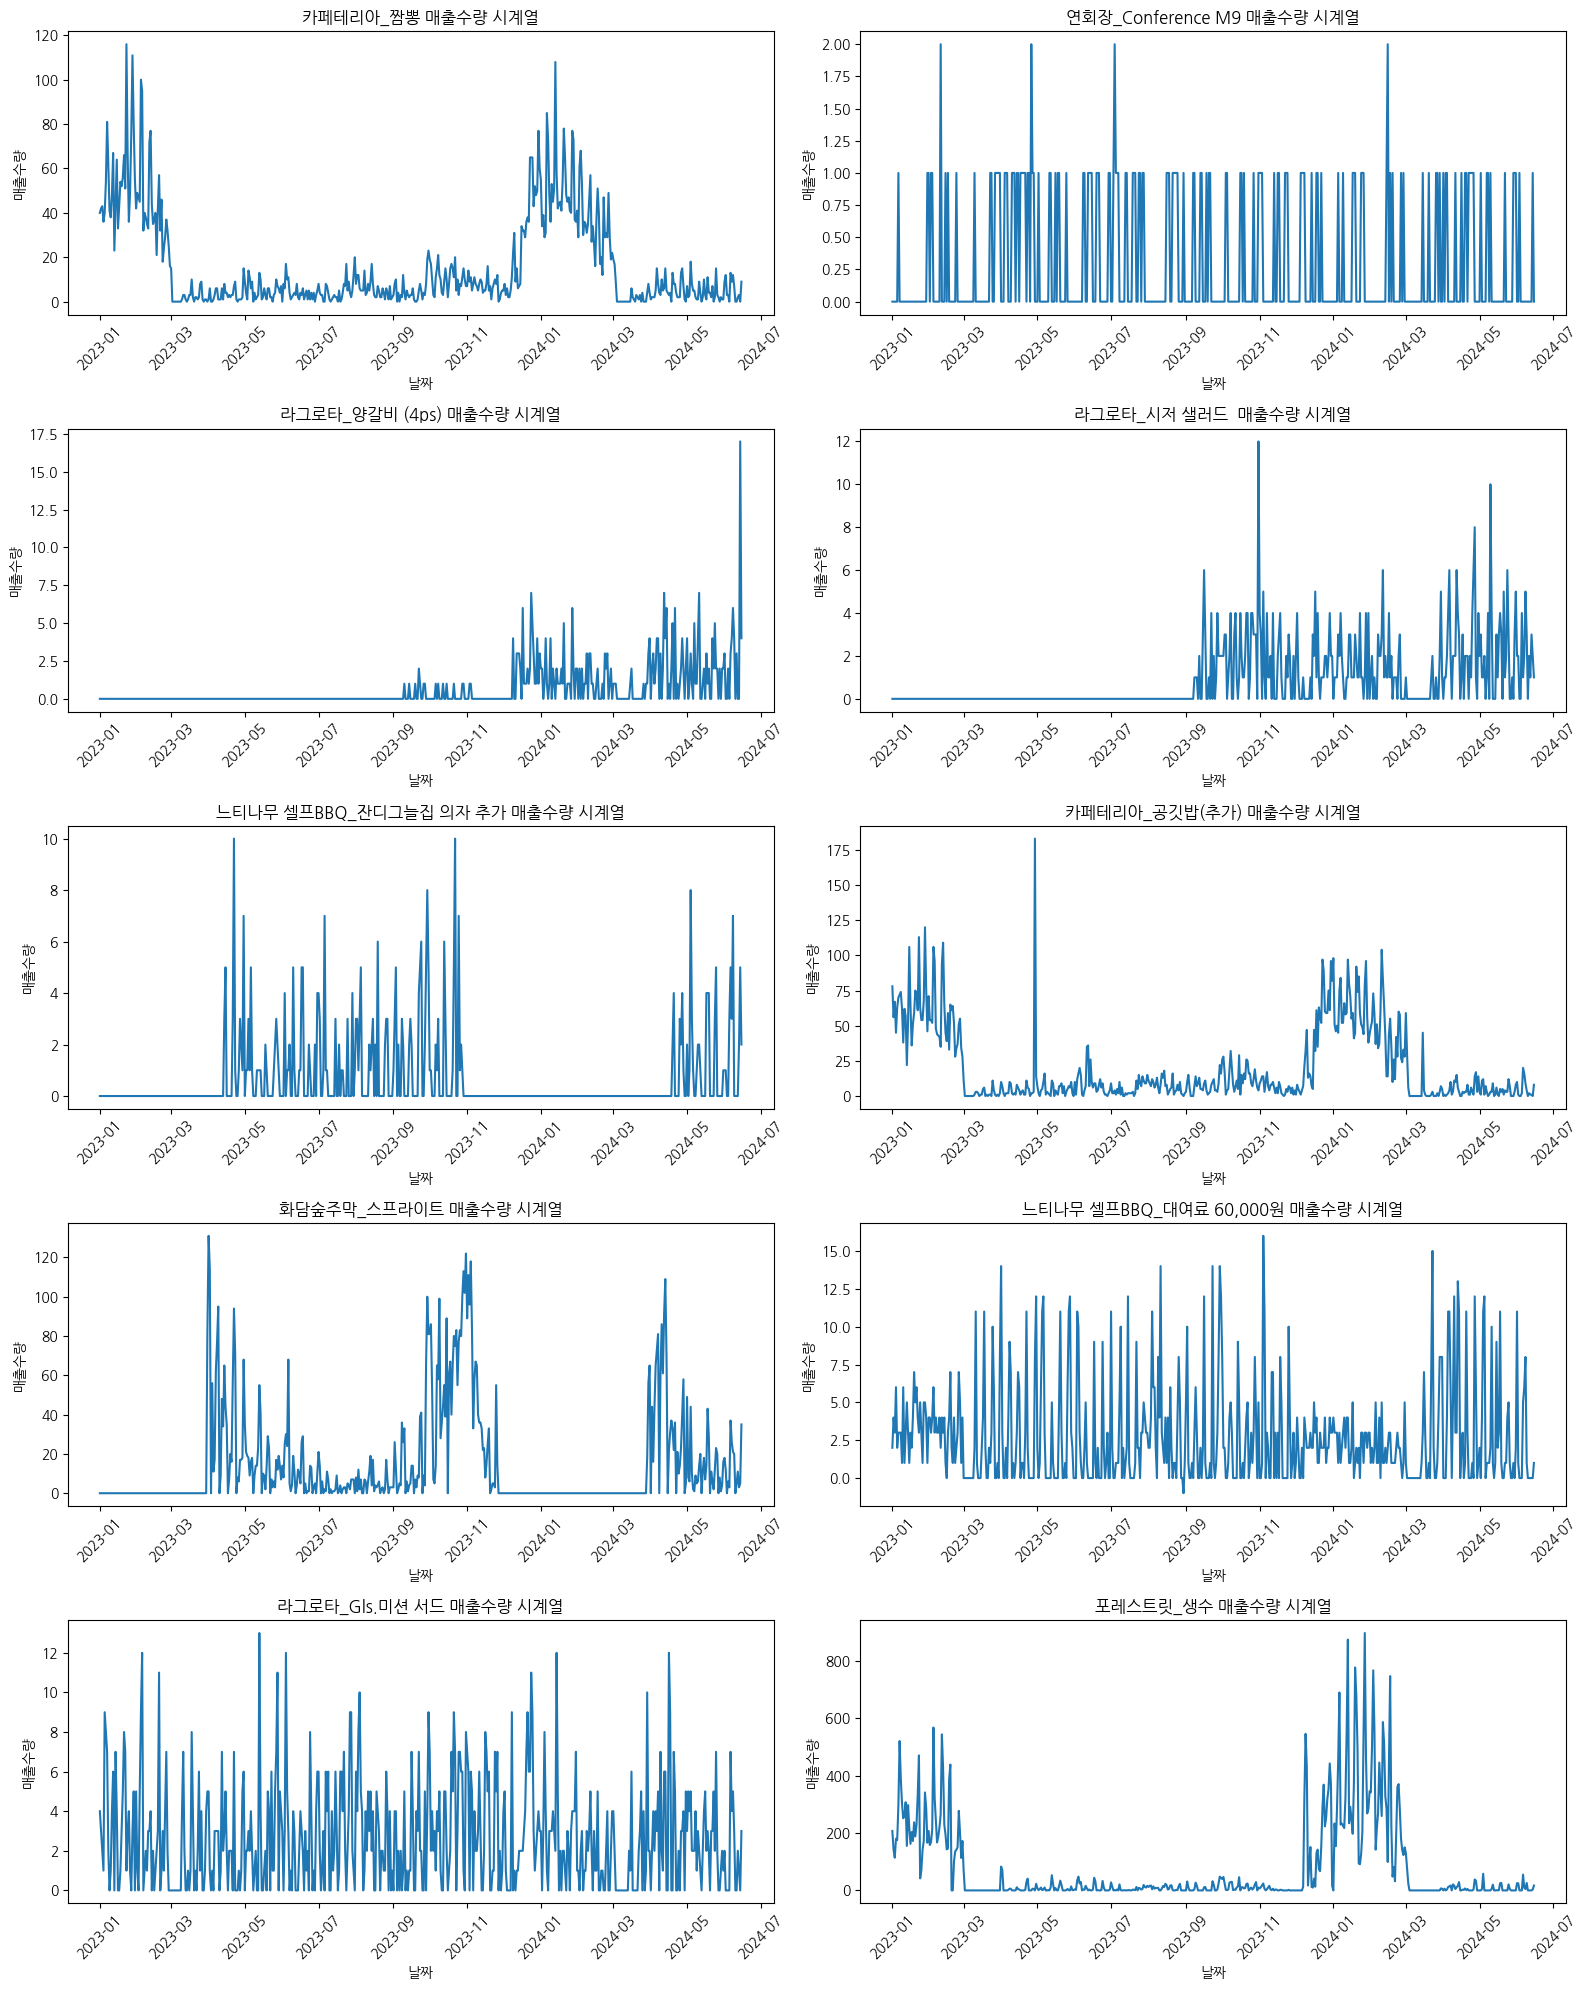

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random

# 메뉴명 리스트 중에서 랜덤하게 10개 선택
random_menus = random.sample(list(df['영업장명_메뉴명'].unique()), 10)

# 시각화
plt.figure(figsize=(16, 20))  # 10개의 서브플롯을 위해 세로로 큼직하게

for i, menu in enumerate(random_menus, 1):
    plt.subplot(5, 2, i)
    ts = df[df['영업장명_메뉴명'] == menu].groupby('영업일자')['매출수량'].sum().sort_index()
    plt.plot(ts.index, ts.values)
    plt.title(f"{menu} 매출수량 시계열")
    plt.xlabel("날짜")
    plt.ylabel("매출수량")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
def conditional_median_imputation(df, max_zero_gap=2, return_count=True):
    imputed_data = []
    total_imputed = 0  # 전체 보간 개수

    for key in tqdm(df['영업장명_메뉴명'].unique(), desc="Imputing by store_menu"):
        temp = df[df['영업장명_메뉴명'] == key].copy()
        ts = temp.set_index('영업일자').sort_index()['매출수량']

        values = ts.values.copy()
        original_values = values.copy()
        median_val = ts[ts != 0].median()

        i = 0
        while i < len(values):
            if values[i] == 0:
                start = i
                while i < len(values) and values[i] == 0:
                    i += 1
                end = i

                if start > 0 and end < len(values) and (end - start) <= max_zero_gap:
                    values[start:end] = median_val
            else:
                i += 1

        imputed_ts = pd.Series(values, index=ts.index)

        # 몇 개 보간됐는지 계산
        imputed_mask = (original_values != values)
        imputed_count = np.sum(imputed_mask)
        total_imputed += imputed_count

        result = pd.DataFrame({
            '영업일자': ts.index,
            '매출수량': values,
            '영업장명_메뉴명': key
        })

        imputed_data.append(result)

    result_df = pd.concat(imputed_data)

    if return_count:
        print(f"총 보간된 지점 수: {total_imputed:,}개")

    return result_df

# 연속된 0이 3개 이하일 때만 보간
train_df = conditional_median_imputation(df, max_zero_gap=3)


Imputing by store_menu: 100%|██████████| 193/193 [00:03<00:00, 50.10it/s]

총 보간된 지점 수: 13,535개


In [ ]:
train_df.head()

,영업일자,매출수량,영업장명_메뉴명
0,2023-01-01,0,느티나무 셀프BBQ_1인 수저세트
1,2023-01-02,0,느티나무 셀프BBQ_1인 수저세트
2,2023-01-03,0,느티나무 셀프BBQ_1인 수저세트
3,2023-01-04,0,느티나무 셀프BBQ_1인 수저세트
4,2023-01-05,0,느티나무 셀프BBQ_1인 수저세트


In [ ]:
# 날짜 형식으로 변환
train_df['영업일자'] = pd.to_datetime(train_df['영업일자'])

# 영업장명, 메뉴명 분리
train_df[['영업장명', '메뉴명']] =train_df['영업장명_메뉴명'].str.split('_', n=1, expand=True)

# 파생 컬럼 생성
train_df['월'] = train_df['영업일자'].dt.month
train_df['요일'] = train_df['영업일자'].dt.weekday #월요일:0
train_df['분기'] = train_df['영업일자'].dt.quarter
train_df = train_df.sort_values(by=['영업장명_메뉴명', '영업일자'])
train_df["주말여부"] = train_df["요일"].apply(lambda x: '주말' if x >= 5 else '평일')


In [ ]:
!pip install --force-reinstall korean-lunar-calendar==0.2.1

In [ ]:
from datetime import date, timedelta
from korean_lunar_calendar import KoreanLunarCalendar
import pandas as pd

# 최근 7일 평균/표준편차
train_df['rolling_mean_7'] = (
    train_df.groupby('영업장명_메뉴명')['매출수량']
        .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())
)

train_df['rolling_std_7'] = (
    train_df.groupby('영업장명_메뉴명')['매출수량']
        .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).std())
)

# 음력 공휴일 처리 함수
def get_lunar_holiday_range(year, lunar_month, lunar_day, days=3):
    cal = KoreanLunarCalendar()
    cal.setLunarDate(year, lunar_month, lunar_day, False)
    main_day = date.fromisoformat(cal.SolarIsoFormat())
    return [(main_day + timedelta(days=i - 1)) for i in range(days)]

def get_all_korean_holidays(start_year=2023, end_year=2025):
    holiday_dates = []

    for year in range(start_year, end_year + 1):
        fixed = [
            date(year, 1, 1), date(year, 3, 1), date(year, 5, 5),
            date(year, 6, 6), date(year, 8, 15), date(year, 10, 3),
            date(year, 10, 9), date(year, 12, 25)
        ]
        holiday_dates.extend(fixed)
        holiday_dates.extend(get_lunar_holiday_range(year, 1, 1))   # 설날
        holiday_dates.extend(get_lunar_holiday_range(year, 8, 15))  # 추석

        # 부처님 오신날
        cal = KoreanLunarCalendar()
        cal.setLunarDate(year, 4, 8, False)
        buddha_day = date.fromisoformat(cal.SolarIsoFormat())
        holiday_dates.append(buddha_day)

    return pd.to_datetime(sorted(set(holiday_dates)))

# 공휴일 여부 파생변수
start_year = train_df['영업일자'].dt.year.min()
end_year = train_df['영업일자'].dt.year.max()
holidays = get_all_korean_holidays(start_year, end_year)

train_df['공휴일여부'] = train_df['영업일자'].isin(holidays).astype(int)

# lag 1~7 생성
for i in range(1, 8):
    train_df[f'lag{i}'] = train_df.groupby('영업장명_메뉴명')['매출수량'].shift(i)

# 변동계수(cv) 생성 및 표준편차 피처 제거
train_df['cv_7'] = train_df['rolling_std_7'] / (train_df['rolling_mean_7'] + 1e-5)
train_df.drop(columns=['rolling_std_7'], inplace=True)

# 결측 제거 및 인덱스 초기화
train_df = train_df.dropna().reset_index(drop=True)


ModuleNotFoundError: No module named 'korean_lunar_calendar'

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102676 entries, 0 to 531
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   영업일자      102676 non-null  datetime64[ns]
 1   매출수량      102676 non-null  int64         
 2   영업장명_메뉴명  102676 non-null  object        
 3   영업장명      102676 non-null  object        
 4   메뉴명       102676 non-null  object        
 5   월         102676 non-null  int32         
 6   요일        102676 non-null  int32         
 7   분기        102676 non-null  int32         
 8   주말여부      102676 non-null  object        
dtypes: datetime64[ns](1), int32(3), int64(1), object(4)
memory usage: 6.7+ MB


In [ ]:
len(df[df['매출수량']<0])

14

음수인 데이터가 존재함(반품/취소 가능성)

In [ ]:
len(df[df['매출수량']==0])

54034

0값인 데이터가 전체 데이터의 반 이상을 차지함

In [ ]:
#영업장별 매출 수량 확인
df.groupby('영업장명')['매출수량'].sum().sort_values(ascending=False).head(10)

,매출수량
영업장명,
포레스트릿,305421
카페테리아,240850
화담숲주막,146311
담하,124917
미라시아,98071
느티나무 셀프BBQ,69786
화담숲카페,62634
연회장,28373
라그로타,17453


영업장별로 매출 수량이 상이함

In [ ]:
# 영업장별, 메뉴별 매출수량 합계 계산
grouped = df.groupby(['영업장명', '메뉴명'])['매출수량'].sum().reset_index()

# 매출수량 기준 내림차순 정렬
grouped_sales = grouped.sort_values(by='매출수량', ascending=False)
grouped_sales.reset_index(drop=True, inplace=True)
display(grouped_sales.head(10))

,영업장명,메뉴명,매출수량
0,포레스트릿,꼬치어묵,68733
1,화담숲주막,해물파전,60126
2,포레스트릿,떡볶이,56424
3,포레스트릿,생수,41445
4,포레스트릿,치즈 핫도그,30402
5,카페테리아,수제 등심 돈까스,27336
6,카페테리아,단체식 18000(신),26571
7,화담숲카페,아메리카노 ICE,22525
8,포레스트릿,코카콜라,22035
9,포레스트릿,아메리카노(ICE),21000


In [ ]:
df.groupby('영업장명')['메뉴명'].nunique()

,메뉴명
영업장명,
느티나무 셀프BBQ,23
담하,42
라그로타,25
미라시아,31
연회장,23
카페테리아,24
포레스트릿,12
화담숲주막,8
화담숲카페,5


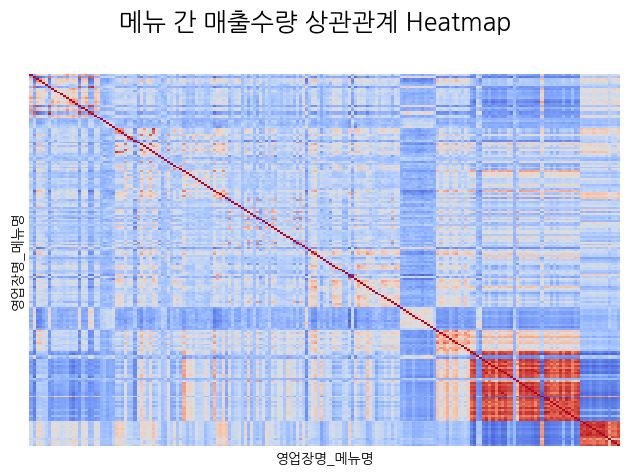

In [ ]:
pivot = df.pivot_table(index='영업일자', columns='영업장명_메뉴명', values='매출수량', aggfunc='sum', fill_value=0)
corr = pivot.corr()

sns.heatmap(corr, cmap='coolwarm', cbar=False, xticklabels=False, yticklabels=False)

plt.suptitle("메뉴 간 매출수량 상관관계 Heatmap", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

메뉴별로 클러스터링 될 수 있음(block형태가 보임)

In [ ]:
df.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명,월,요일
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,6
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,1
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,2
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,3


In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# 1. 피벗 테이블 생성: 메뉴별로 일자 기준 매출수량 테이블
pivot_df = df.pivot_table(index='영업일자', columns='영업장명_메뉴명', values='매출수량', aggfunc='sum', fill_value=0)

# 2. 상관계수 → 거리행렬
corr_matrix = pivot_df.corr()
distance_matrix = 1 - corr_matrix
condensed_dist = squareform(distance_matrix)

# 3. 계층적 클러스터링
linkage_matrix = linkage(condensed_dist, method='ward')

# 5. 클러스터 개수 선택 및 할당
n_clusters = 7 # (히트맵 블록 수 기준으로 조절 가능)
cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# 6. 클러스터 결과 저장
cluster_df = pd.DataFrame({
    '영업장명_메뉴명': corr_matrix.columns,
    '클러스터': cluster_labels
})

# 7. 클러스터별 메뉴 개수 확인
print("📊 클러스터별 메뉴 개수:")
print(cluster_df['클러스터'].value_counts().sort_index())


📊 클러스터별 메뉴 개수:
클러스터
1    31
2    31
3    29
4    29
5    41
6    14
7    18
Name: count, dtype: int64


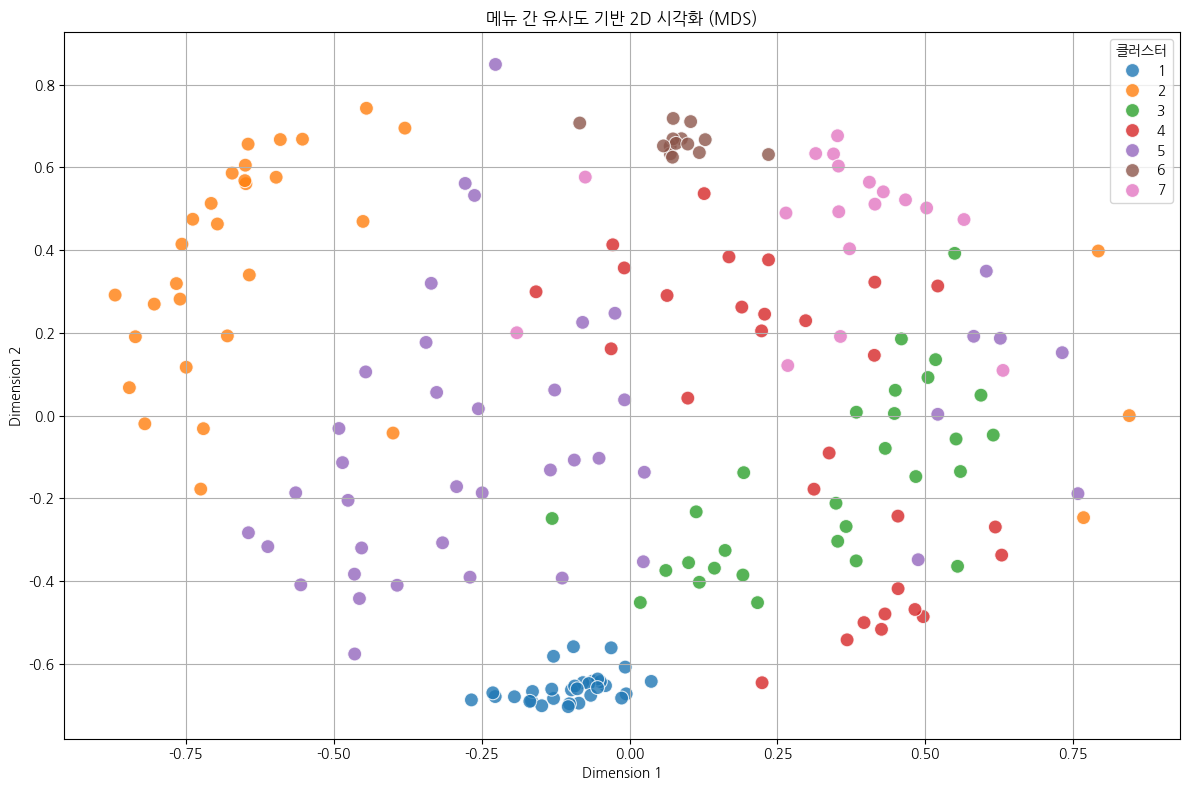

In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 상관계수 행렬 → 거리 행렬 (1 - corr)
dist_matrix = 1 - corr_matrix

# 2. MDS (다차원 척도법) 수행
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(dist_matrix)

# 3. 결과를 데이터프레임으로 정리
mds_df = pd.DataFrame(mds_coords, columns=['x', 'y'])
mds_df['메뉴명'] = corr_matrix.columns
mds_df['클러스터'] = cluster_labels  # 기존에 구한 클러스터 정보 사용

# 4. 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=mds_df, x='x', y='y', hue='클러스터', palette='tab10', s=100, alpha=0.8)
plt.title("메뉴 간 유사도 기반 2D 시각화 (MDS)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend(title="클러스터")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# 1. 피벗 테이블 생성: 메뉴별로 일자 기준 매출수량 테이블
pivot_df = df.pivot_table(index='영업일자', columns='영업장명_메뉴명', values='매출수량', aggfunc='sum', fill_value=0)

# 2. 상관계수 → 거리행렬
corr_matrix = pivot_df.corr()
distance_matrix = 1 - corr_matrix
condensed_dist = squareform(distance_matrix)

# 1단계: 상관계수 0.85 이상인 메뉴 추출
threshold_high = 0.85
high_corr_pairs = (corr_matrix > threshold_high).sum(axis=1)
selected_menus_lvl1 = high_corr_pairs[high_corr_pairs > 1].index
corr_lvl1 = corr_matrix.loc[selected_menus_lvl1, selected_menus_lvl1]

# 2단계: 0.7 이상 관계 중심 클러스터링
threshold_low = 0.7
filtered = corr_lvl1.copy()
filtered[filtered < threshold_low] = threshold_low  # 너무 낮은 값은 무시

# 거리 행렬 및 linkage
dist_lvl2 = 1 - filtered
linkage_lvl2 = linkage(dist_lvl2, method='ward')

# 클러스터링 (예: 3개 그룹)
cluster_labels = fcluster(linkage_lvl2, t=3, criterion='maxclust')

# 결과 매핑
cluster_map = pd.Series(0, index=corr_matrix.index)
cluster_map.loc[selected_menus_lvl1] = cluster_labels
# 각 클러스터별 메뉴 수 확인
print(cluster_map.value_counts().sort_index())


0    143
1     30
2     12
3      8
Name: count, dtype: int64


/tmp/ipython-input-1212960047.py:24: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_lvl2 = linkage(dist_lvl2, method='ward')


In [ ]:
# 클러스터 번호별로 어떤 메뉴들이 포함되어 있는지 출력
for cluster_id in sorted(cluster_map.unique()):
    menus_in_cluster = cluster_map[cluster_map == cluster_id].index.tolist()
    print(f"\n📦 클러스터 {cluster_id} ({len(menus_in_cluster)}개):")
    for menu in menus_in_cluster:
        print(f" - {menu}")



📦 클러스터 0 (143개):
 - 느티나무 셀프BBQ_1인 수저세트
 - 느티나무 셀프BBQ_BBQ55(단체)
 - 느티나무 셀프BBQ_대여료 30,000원
 - 느티나무 셀프BBQ_대여료 60,000원
 - 느티나무 셀프BBQ_대여료 90,000원
 - 느티나무 셀프BBQ_본삼겹 (단품,실내)
 - 느티나무 셀프BBQ_신라면
 - 느티나무 셀프BBQ_쌈야채세트
 - 느티나무 셀프BBQ_쌈장
 - 느티나무 셀프BBQ_육개장 사발면
 - 느티나무 셀프BBQ_일회용 소주컵
 - 느티나무 셀프BBQ_일회용 종이컵
 - 느티나무 셀프BBQ_잔디그늘집 대여료 (12인석)
 - 느티나무 셀프BBQ_잔디그늘집 대여료 (6인석)
 - 느티나무 셀프BBQ_잔디그늘집 의자 추가
 - 느티나무 셀프BBQ_친환경 접시 14cm
 - 느티나무 셀프BBQ_친환경 접시 23cm
 - 느티나무 셀프BBQ_햇반
 - 느티나무 셀프BBQ_허브솔트
 - 담하_(단체) 공깃밥
 - 담하_(단체) 생목살 김치전골 2.0
 - 담하_(단체) 은이버섯 갈비탕
 - 담하_(단체) 한우 우거지 국밥
 - 담하_(단체) 황태해장국 3/27까지
 - 담하_(정식) 물냉면 
 - 담하_(정식) 비빔냉면
 - 담하_(후식) 된장찌개
 - 담하_(후식) 물냉면
 - 담하_(후식) 비빔냉면
 - 담하_갑오징어 비빔밥
 - 담하_갱시기
 - 담하_꼬막 비빔밥
 - 담하_느린마을 막걸리
 - 담하_더덕 한우 지짐
 - 담하_들깨 양지탕
 - 담하_라면사리
 - 담하_룸 이용료
 - 담하_메밀면 사리
 - 담하_명인안동소주
 - 담하_명태회 비빔냉면
 - 담하_문막 복분자 칵테일
 - 담하_봉평메밀 물냉면
 - 담하_생목살 김치찌개
 - 담하_스프라이트
 - 담하_은이버섯 갈비탕
 - 담하_제로콜라
 - 담하_참이슬
 - 담하_처음처럼
 - 담하_카스
 - 담하_콜라
 - 담하_테라
 - 담하_하동 매실 칵테일
 - 담하_한우 떡갈비 정식
 - 담하_한우 미역국 정식
 - 담하_한우 우거지 국밥
 - 담하_한우 차돌

In [ ]:
# df에 '메뉴클러스터' 컬럼 추가 (클러스터 정보 병합)
df['메뉴클러스터'] = df['영업장명_메뉴명'].map(cluster_map)
df.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명,월,요일,메뉴클러스터
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,6,0
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,0,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,1,0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,2,0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,3,0


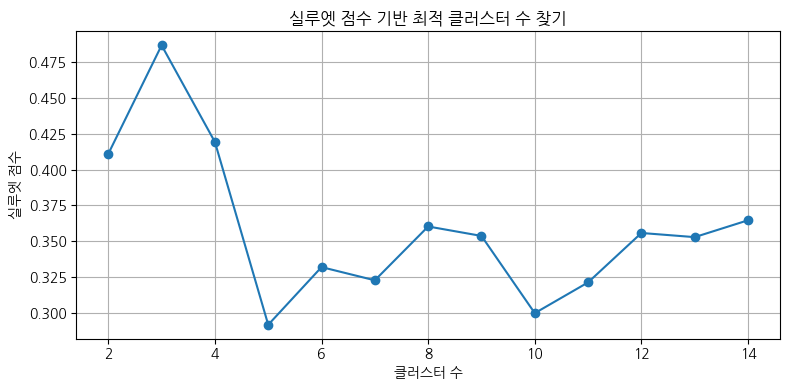

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
sil_scores = []
range_n = range(2, min(15, len(dist_lvl2)))  # 클러스터 수 범위

for k in range_n:
    labels = fcluster(linkage_lvl2, k, criterion='maxclust')
    score = silhouette_score(dist_lvl2, labels, metric='precomputed')
    sil_scores.append((k, score))

# 시각화
ks, scores = zip(*sil_scores)
plt.figure(figsize=(8, 4))
plt.plot(ks, scores, marker='o')
plt.title("실루엣 점수 기반 최적 클러스터 수 찾기")
plt.xlabel("클러스터 수")
plt.ylabel("실루엣 점수")
plt.grid(True)
plt.tight_layout()
plt.show()



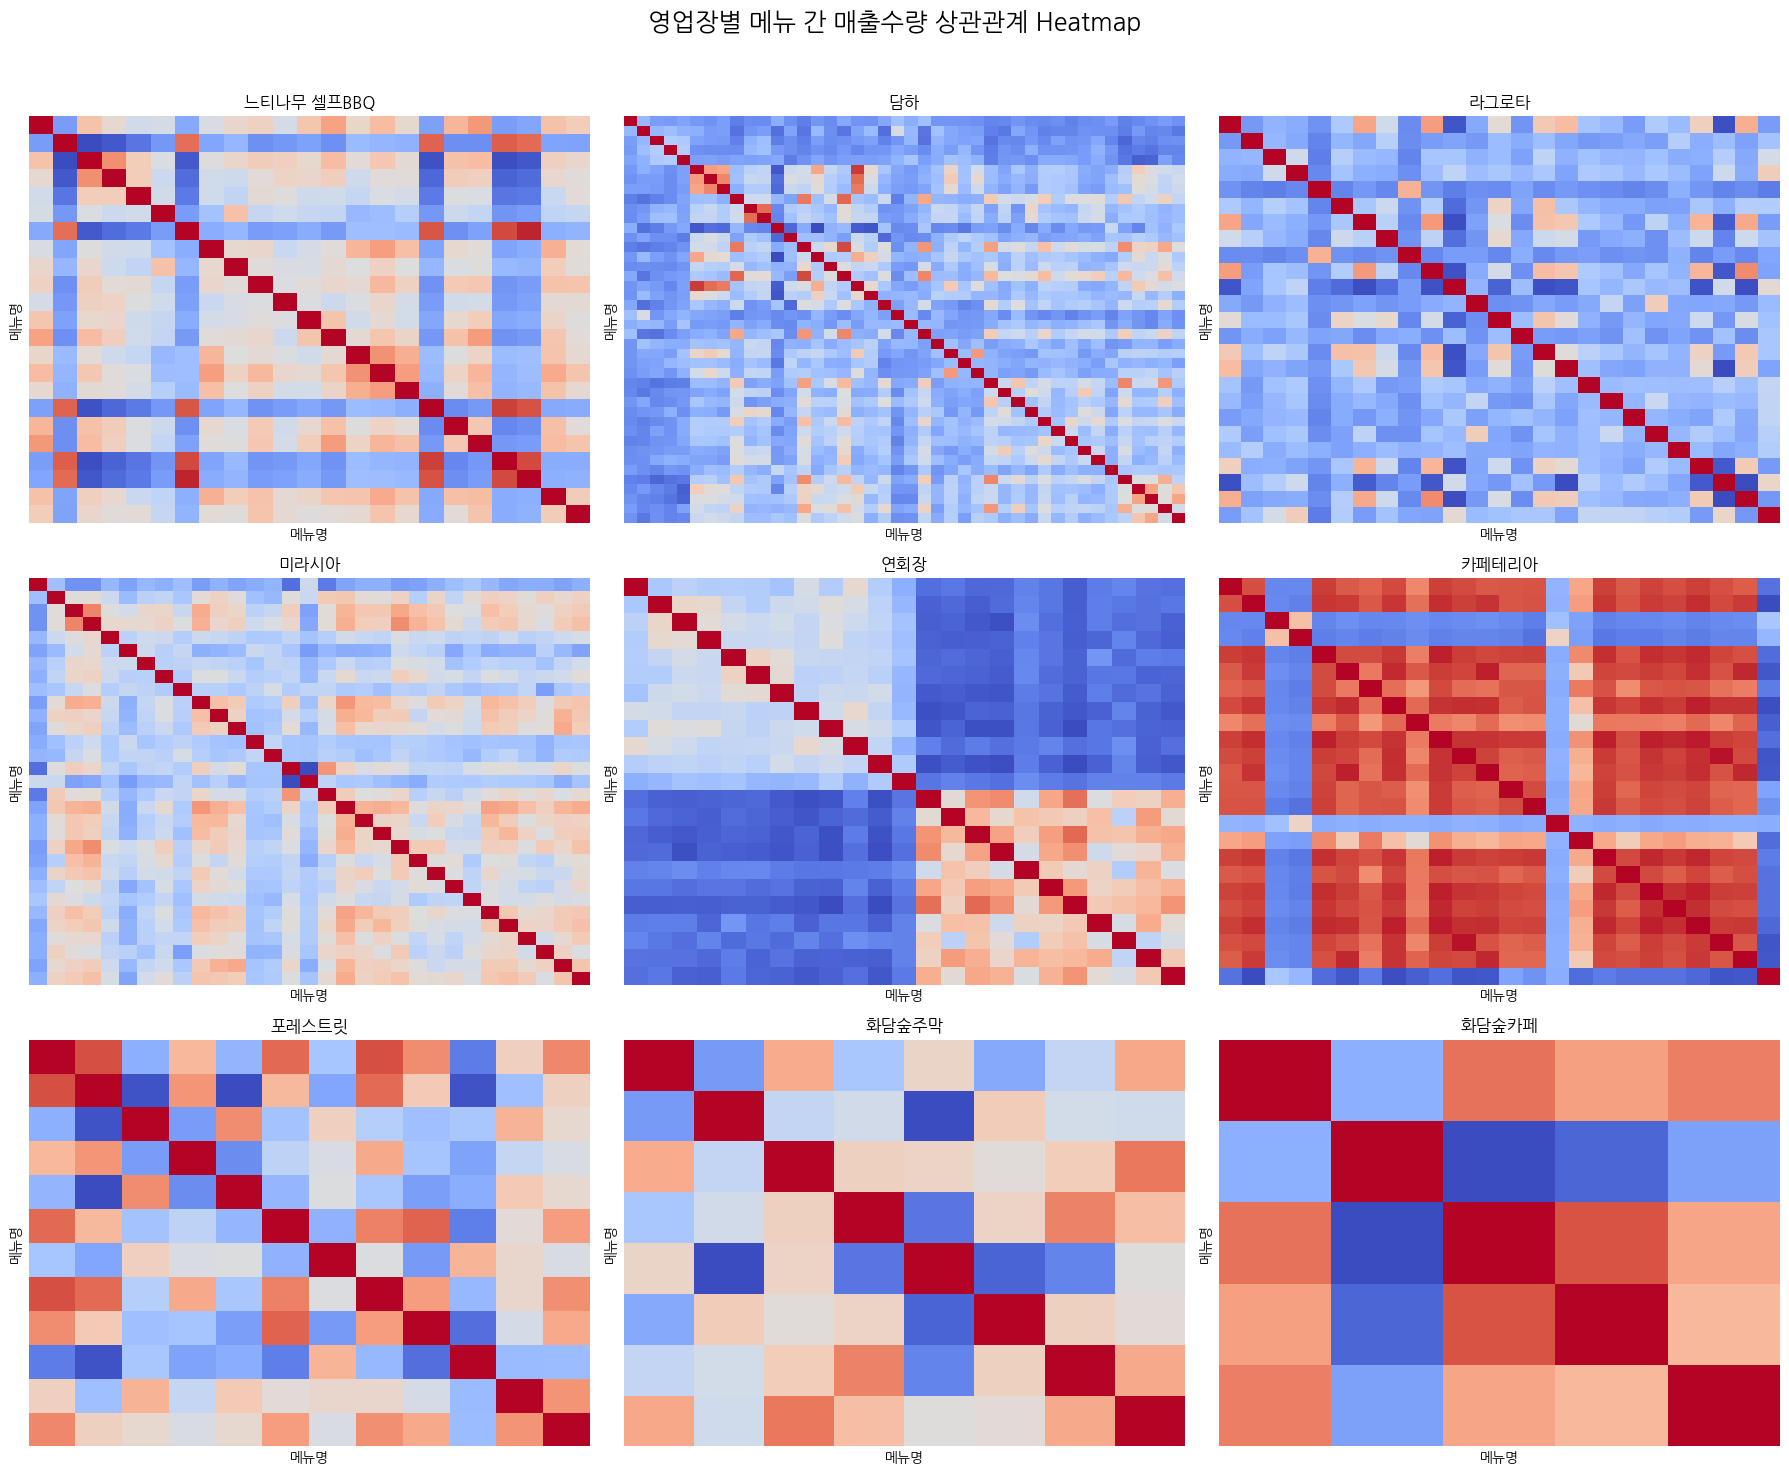

In [ ]:
# 영업장 리스트
stores = df['영업장명'].unique()

# 히트맵 subplot 설정 (최대 9개)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# 상위 9개 영업장별 히트맵 그리기
for i, store in enumerate(stores[:9]):
    store_df = df[df['영업장명'] == store]
    pivot = store_df.pivot_table(index='영업일자', columns='메뉴명', values='매출수량', aggfunc='sum', fill_value=0)
    corr = pivot.corr()

    sns.heatmap(corr, ax=axes[i], cmap='coolwarm', cbar=False, xticklabels=False, yticklabels=False)
    axes[i].set_title(f"{store}")

plt.suptitle("영업장별 메뉴 간 매출수량 상관관계 Heatmap", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

영업장 내에서도 포레스트릿, 화담숲 주막을 제외하고는 메뉴별로 그룹핑되는 상관관계가 있음

느티나무 셀프BBQ


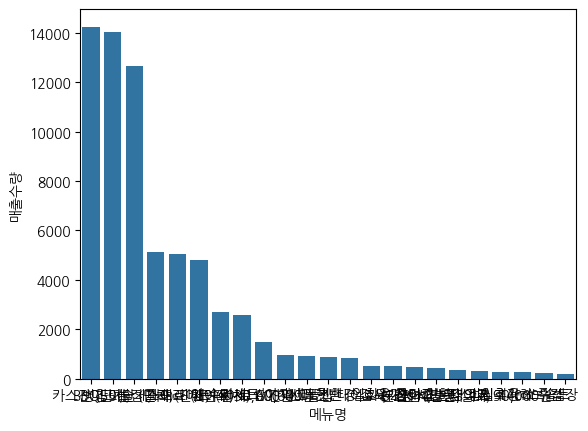

<Figure size 5000x300 with 0 Axes>

담하


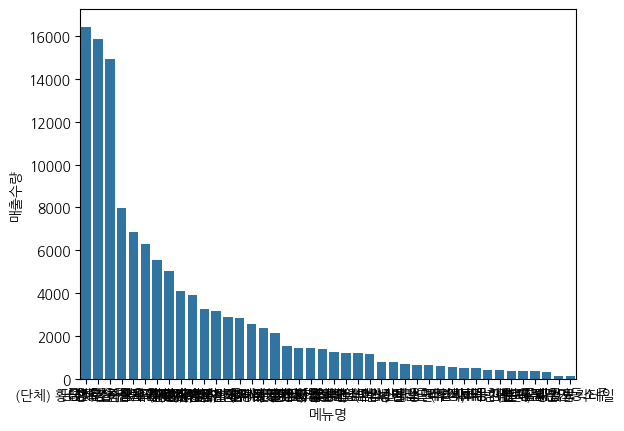

<Figure size 5000x300 with 0 Axes>

라그로타


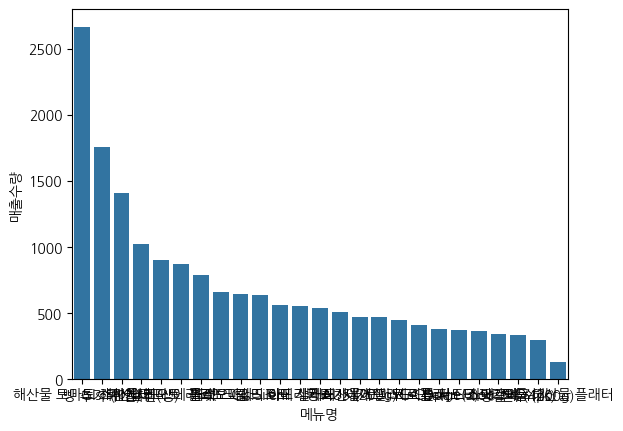

<Figure size 5000x300 with 0 Axes>

미라시아


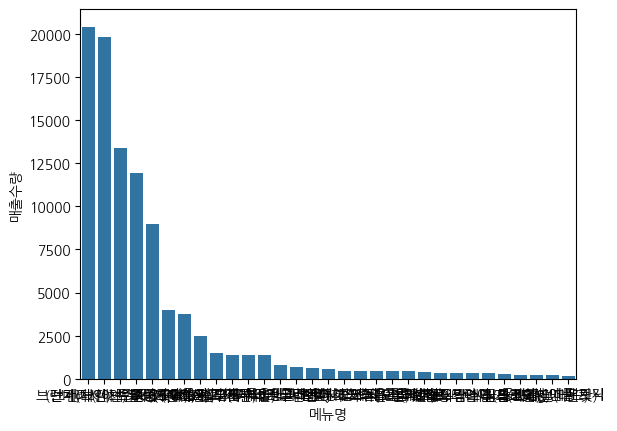

<Figure size 5000x300 with 0 Axes>

연회장


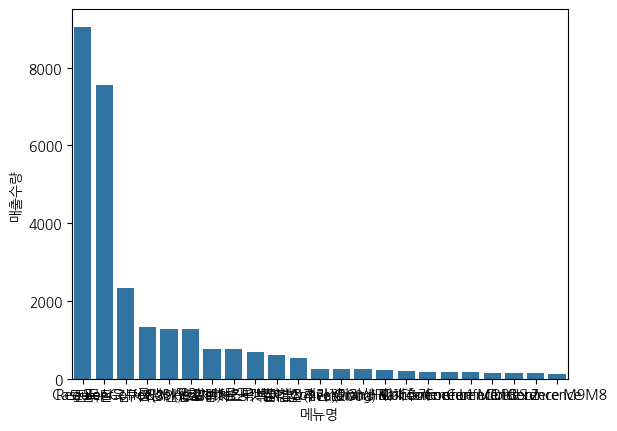

<Figure size 5000x300 with 0 Axes>

카페테리아


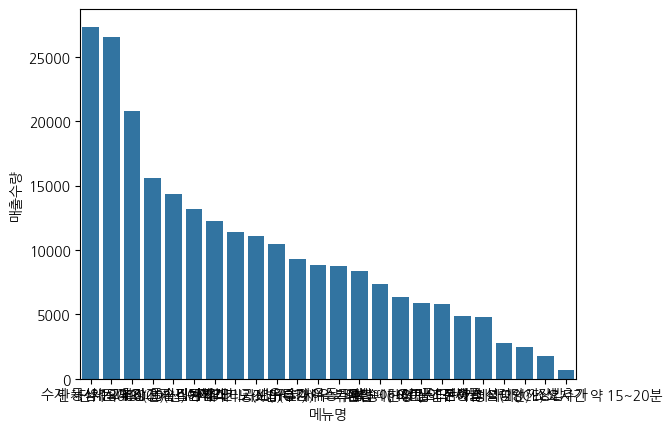

<Figure size 5000x300 with 0 Axes>

포레스트릿


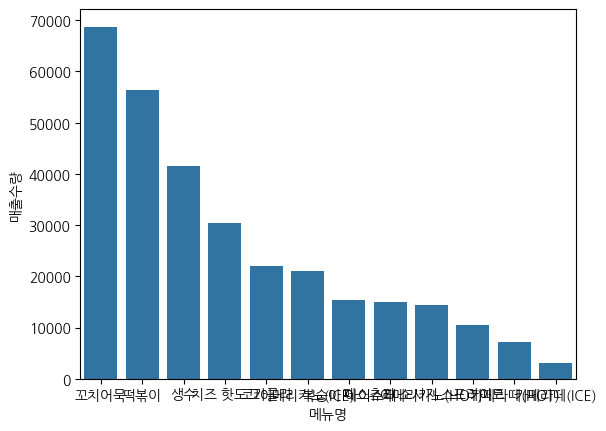

<Figure size 5000x300 with 0 Axes>

화담숲주막


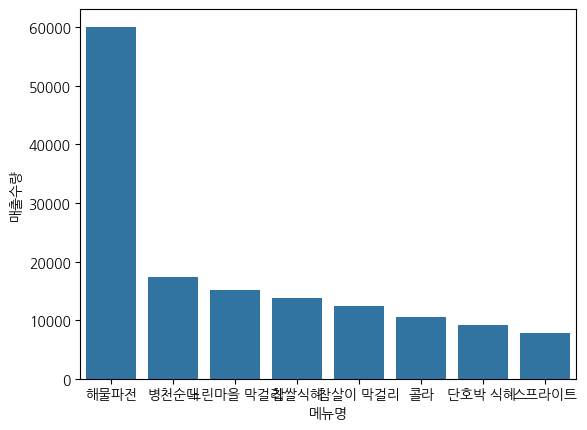

<Figure size 5000x300 with 0 Axes>

화담숲카페


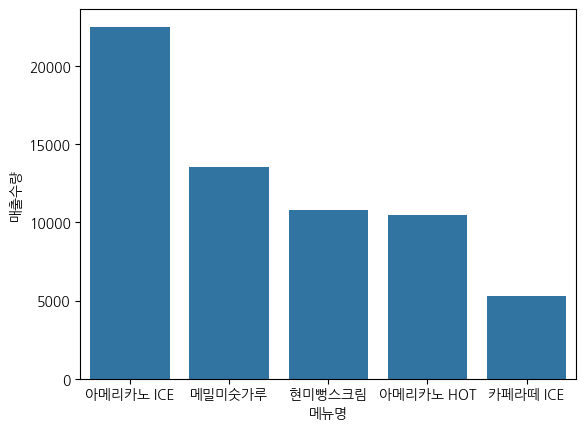

<Figure size 5000x300 with 0 Axes>

In [ ]:
rest=list(df['영업장명'].unique())
a={}
for i in rest:
    a[i]= df[df['영업장명'] == i].groupby('메뉴명')['매출수량'].sum().sort_values(ascending=False)
    print(i)
    sns.barplot(a[i])
    plt.figure(figsize=(50, 3))
    plt.show()

메뉴별 매출 수량이 상이함을 알 수 있음

/tmp/ipython-input-63520365.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="영업장명", bbox_to_anchor=(1.02, 1), loc='upper left')


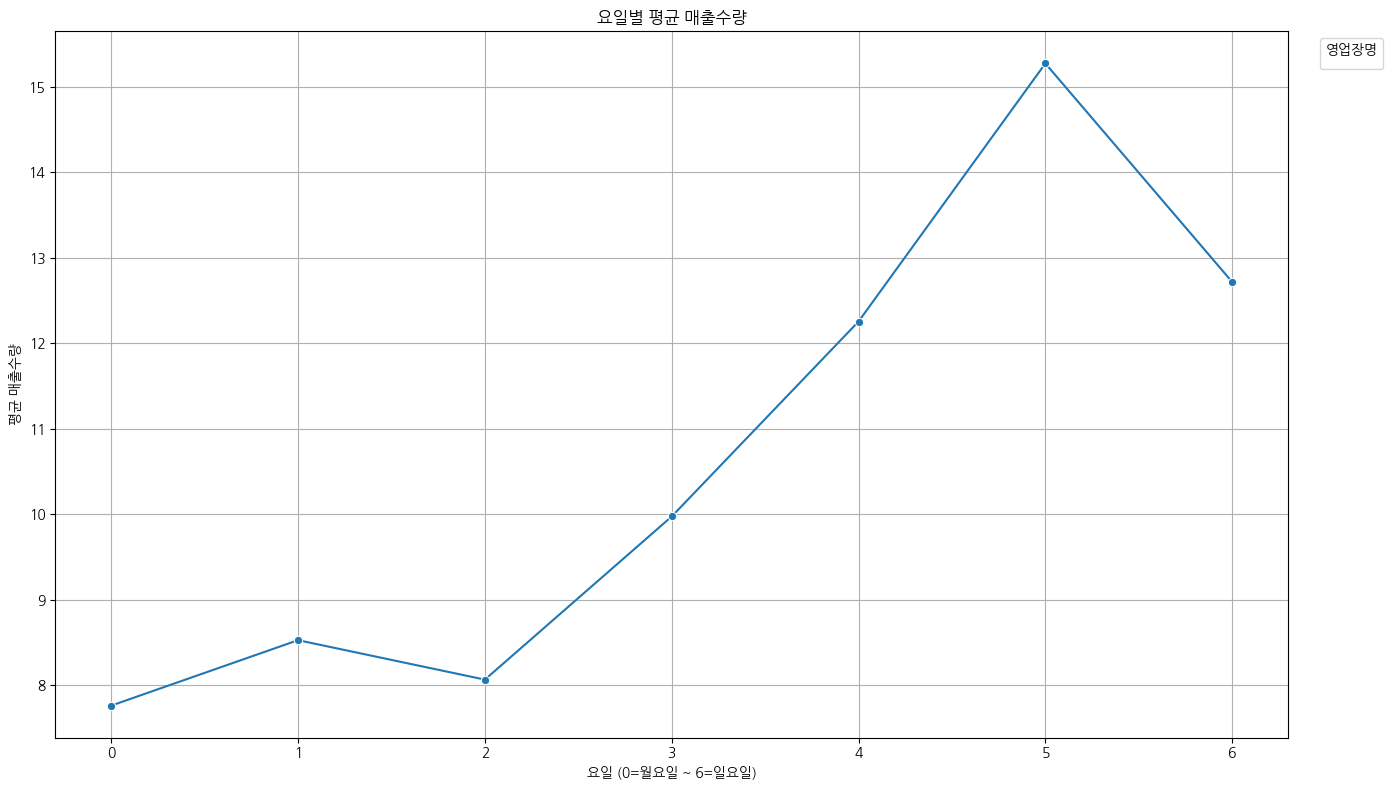

In [ ]:
#업장별 요일별 평균 매출수량 집계
store_weekday_avg = (
    df.groupby(["요일"])["매출수량"]
    .mean()
    .reset_index()
)

#시각화 – 모든 영업장
plt.figure(figsize=(14, 8))
sns.lineplot(data=store_weekday_avg, x="요일", y="매출수량", marker="o")

plt.title("요일별 평균 매출수량")
plt.xlabel("요일 (0=월요일 ~ 6=일요일)")
plt.ylabel("평균 매출수량")
plt.legend(title="영업장명", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

요일별로 판매 수량이 차이가 있음을 알 수 있음

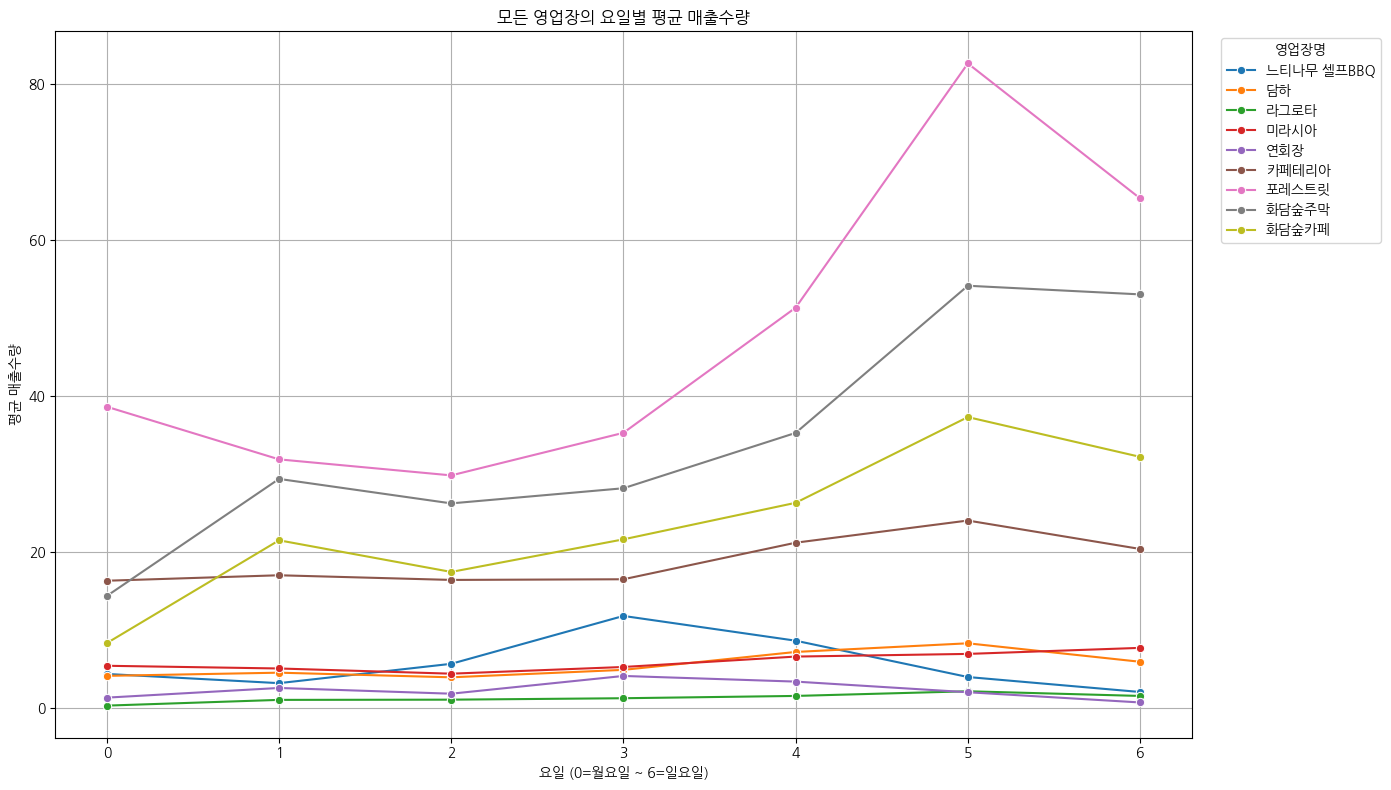

In [ ]:
#업장별 요일별 평균 매출수량 집계
store_weekday_avg = (
    df.groupby(["영업장명", "요일"])["매출수량"]
    .mean()
    .reset_index()
)

#시각화 – 모든 영업장
plt.figure(figsize=(14, 8))
sns.lineplot(data=store_weekday_avg, x="요일", y="매출수량", hue="영업장명", marker="o")

plt.title("모든 영업장의 요일별 평균 매출수량")
plt.xlabel("요일 (0=월요일 ~ 6=일요일)")
plt.ylabel("평균 매출수량")
plt.legend(title="영업장명", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

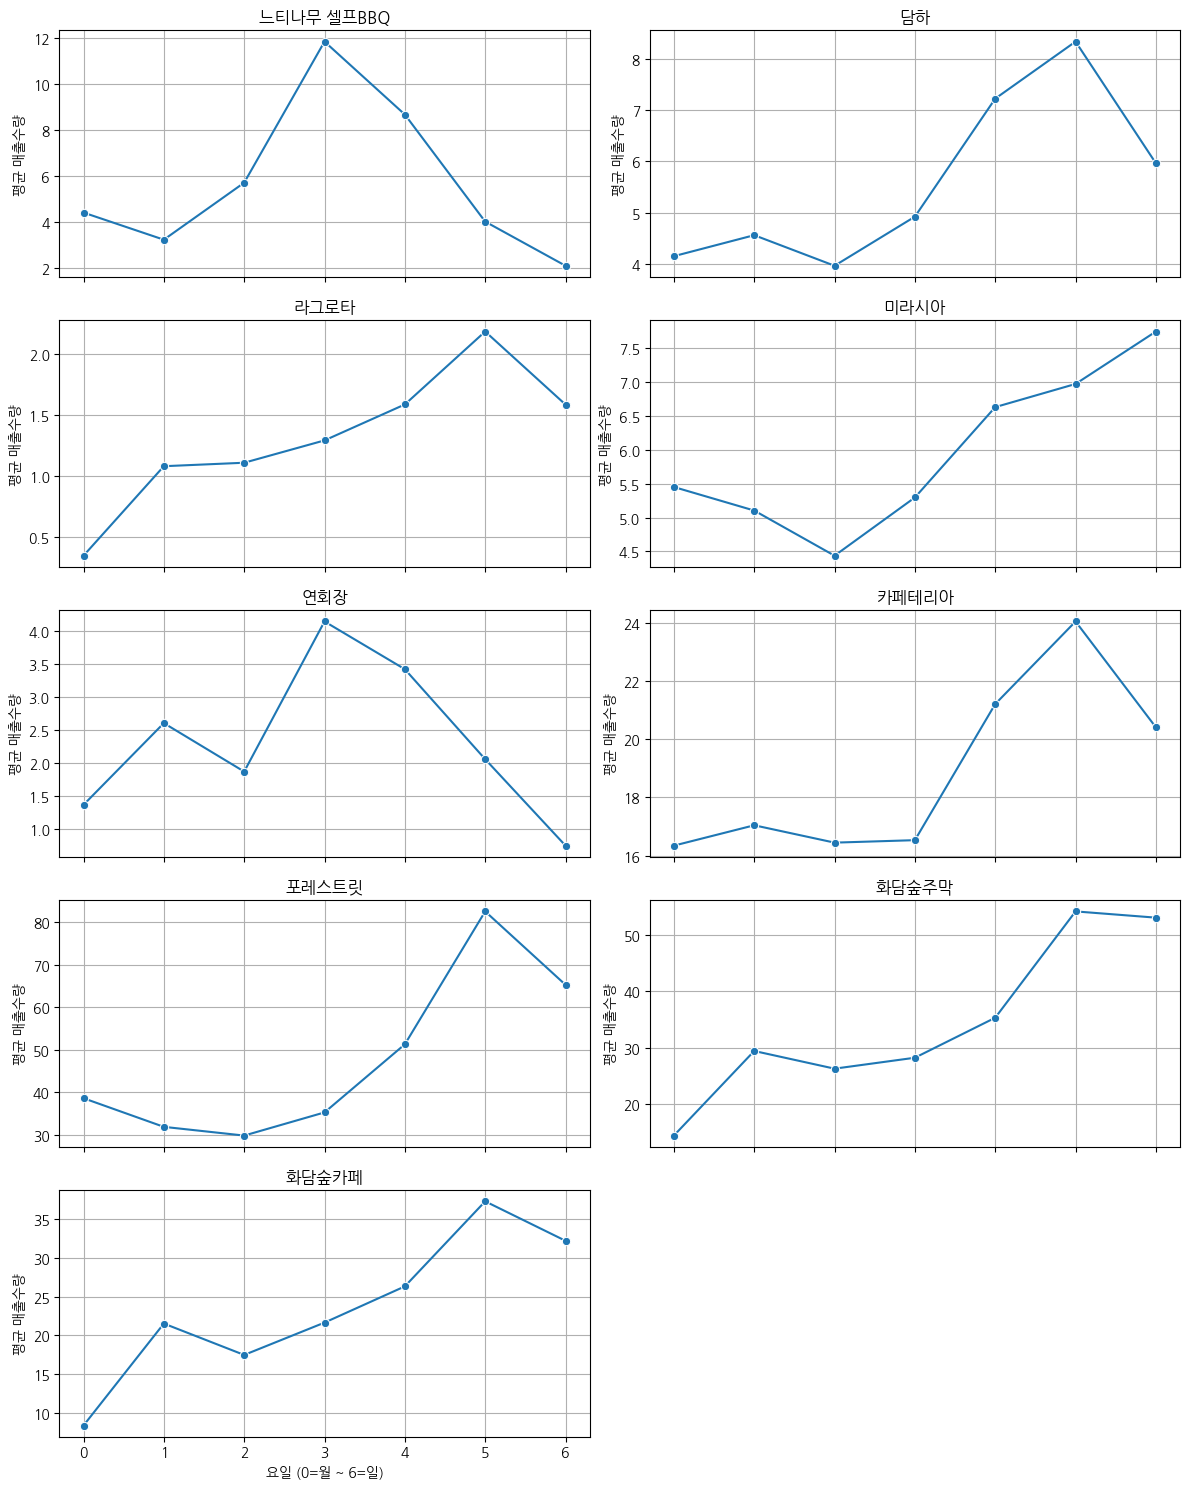

In [ ]:
#업장별 요일 평균 매출수량 계산
store_weekday_avg = (
    df.groupby(["영업장명", "요일"])["매출수량"]
    .mean()
    .reset_index()
)

# 고유 업장 리스트 확인
unique_stores = store_weekday_avg["영업장명"].unique()
n_stores = len(unique_stores)

# subplot 설정 (2열 기준으로 나누기)
ncols = 2
nrows = (n_stores + 1) // ncols  # 올림 처리
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3), sharex=True)

# 축 배열 정리
axes = axes.flatten()

# 각 업장별 subplot에 그래프 그리기
for idx, store in enumerate(unique_stores):
    store_data = store_weekday_avg[store_weekday_avg["영업장명"] == store]
    ax = axes[idx]
    sns.lineplot(data=store_data, x="요일", y="매출수량", marker="o", ax=ax)
    ax.set_title(f"{store}")
    ax.set_xlabel("요일 (0=월 ~ 6=일)")
    ax.set_ylabel("평균 매출수량")
    ax.grid(True)

# 7. 남는 subplot 제거
for i in range(len(unique_stores), len(axes)):
    fig.delaxes(axes[i])

# 8. 마무리
plt.tight_layout()
plt.show()


업장 내 요일별로 판매수량 차이가 있음   
담하와 카페테리아의 추세가 비슷
화담숲주막과 화담숲카페의 추세가 비슷   

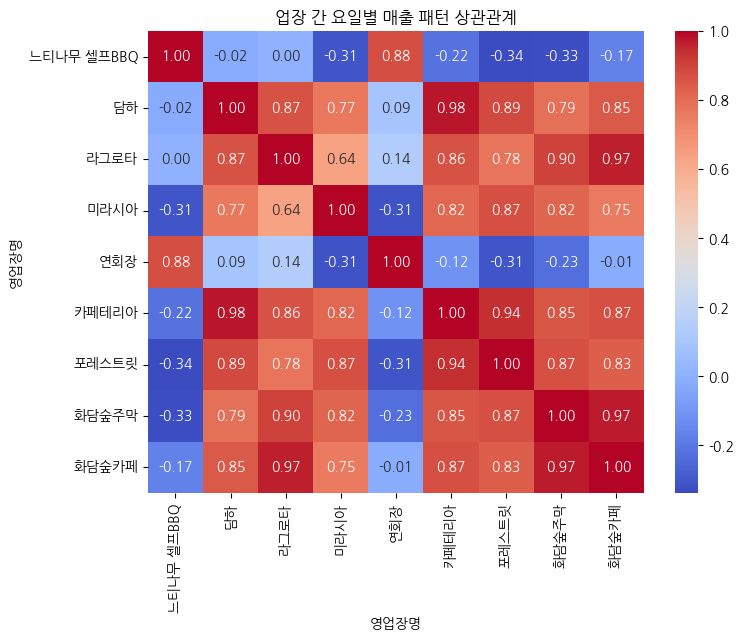

In [ ]:
# 업장별, 요일별 평균 매출 피벗 테이블
pivot_day = df.groupby(['영업장명', '요일'])['매출수량'].mean().unstack().fillna(0)
corr_matrix = pivot_day.T.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('업장 간 요일별 매출 패턴 상관관계')
plt.show()

요일별 매출수량은 느티나무셀프BBQ와 연회장 제외 비슷한 추세

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

# 1. 요일별 평균 매출 피벗 테이블 생성
pivot_day = train_df.groupby(['영업장명_메뉴명', '요일'])['매출수량'].mean().unstack().fillna(0)

# 2. 유사도 → 거리행렬 (상관계수 기반)
corr_matrix = pivot_day.T.corr()  # 메뉴 간 요일패턴 상관계수
distance_matrix = 1 - corr_matrix
condensed_dist = squareform(distance_matrix)

# 3. 계층적 군집화 (예: 3개 클러스터)
linkage_matrix = linkage(condensed_dist, method='ward')
cluster_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')

# 4. 결과 매핑
day_cluster_map = pd.Series(cluster_labels, index=corr_matrix.index)


요일별 매출 패턴 기반 클러스터링 실루엣 점수: 0.2206


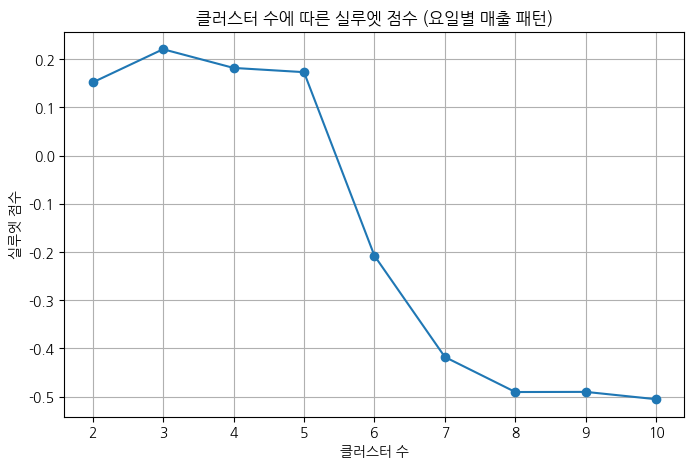

In [ ]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# 1. 데이터 준비 (요일별 매출 벡터)
X = pivot_day.values  # shape: (n_samples, 7)

# 2. 거리 행렬 (상관계수 기반)
corr_matrix = pivot_day.T.corr()
distance_matrix = 1 - corr_matrix
condensed_dist = squareform(distance_matrix)

# 3. linkage 고정 (Ward linkage 기준)
linkage_matrix = linkage(condensed_dist, method='ward')

# 4. 클러스터 수 별 실루엣 점수 계산
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    score = silhouette_score(X, cluster_labels, metric='euclidean')
    silhouette_scores.append(score)

# 5. 시각화
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xticks(range_n_clusters)
plt.xlabel('클러스터 수')
plt.ylabel('실루엣 점수')
plt.title('클러스터 수에 따른 실루엣 점수 (요일별 매출 패턴)')
plt.grid(True)
plt.show()

/tmp/ipython-input-3647241910.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="구분")


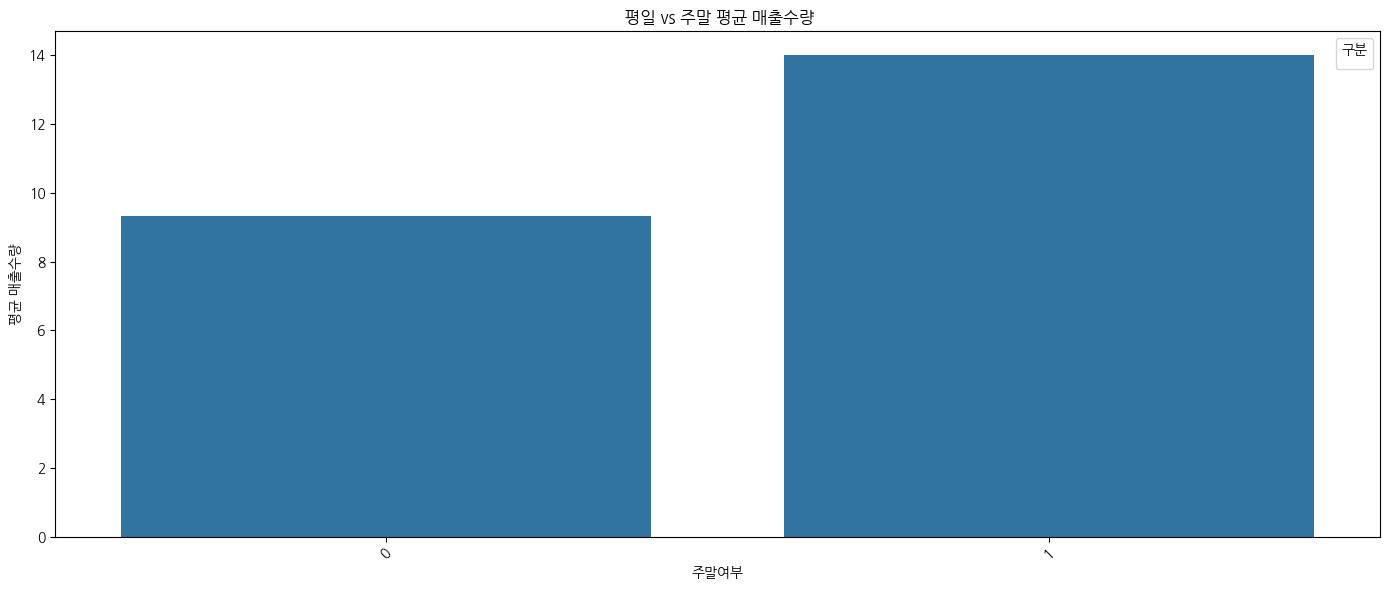

In [ ]:
# 3. 주말 여부 컬럼 생성 (5=토, 6=일 → 주말)
df["주말여부"] = df["요일"].apply(lambda x: 1 if x >= 5 else 0)

# 4. 업장별 평일/주말 평균 매출수량 집계
store_weekend_avg = (
    df.groupby(["주말여부"])["매출수량"]
    .mean()
    .reset_index()
)

# 5. 시각화: 업장별 주말 vs 평일 평균 매출수량 비교 (막대 그래프)
plt.figure(figsize=(14, 6))
sns.barplot(data=store_weekend_avg, x='주말여부', y="매출수량")

plt.title(" 평일 vs 주말 평균 매출수량")
plt.ylabel("평균 매출수량")
plt.xticks(rotation=45)
plt.legend(title="구분")
plt.tight_layout()
plt.show()

주말에 조금 더 매출수량이 많은 경향성

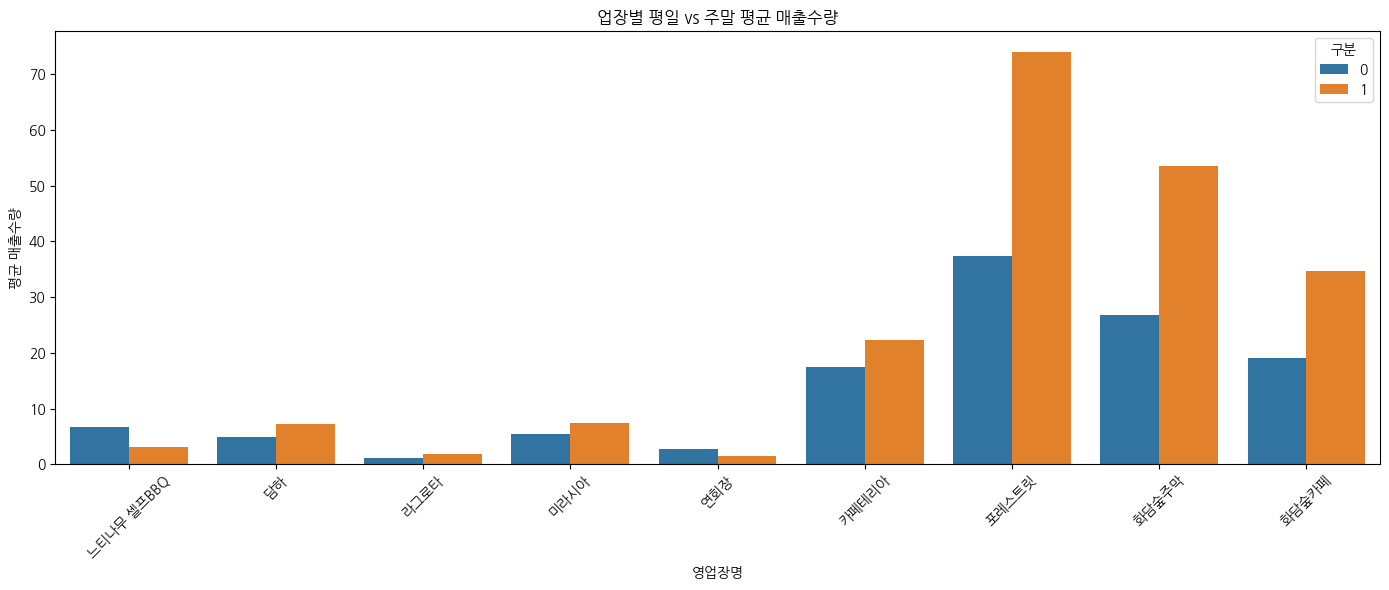

In [ ]:
# 4. 업장별 평일/주말 평균 매출수량 집계
store_weekend_avg = (
    df.groupby(["영업장명", "주말여부"])["매출수량"]
    .mean()
    .reset_index()
)

# 5. 시각화: 업장별 주말 vs 평일 평균 매출수량 비교 (막대 그래프)
plt.figure(figsize=(14, 6))
sns.barplot(data=store_weekend_avg, x="영업장명", y="매출수량", hue="주말여부")

plt.title("업장별 평일 vs 주말 평균 매출수량")
plt.xlabel("영업장명")
plt.ylabel("평균 매출수량")
plt.xticks(rotation=45)
plt.legend(title="구분")
plt.tight_layout()
plt.show()

대부분의 가게에서 주말에 매출이 높음

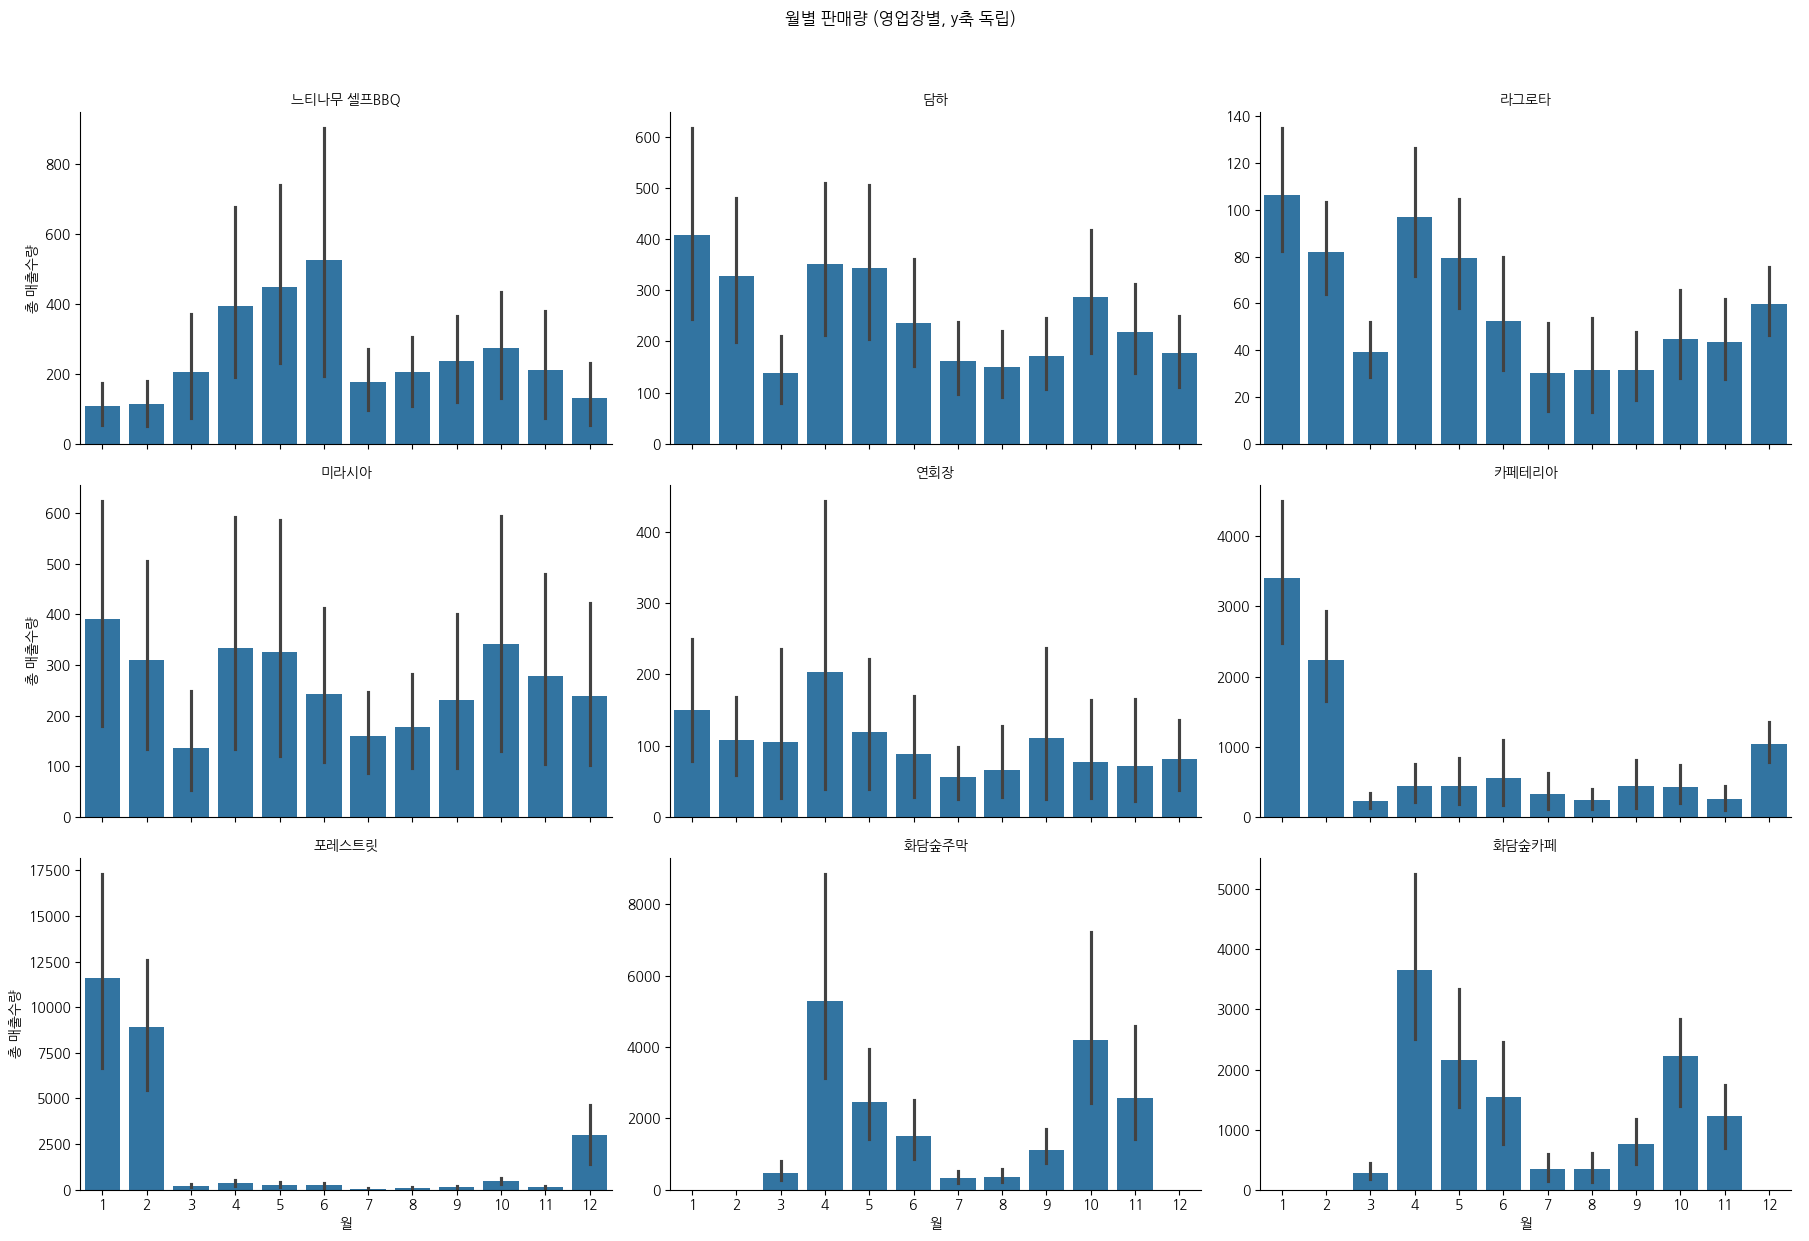

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
def plot_monthly_sales(df):

    monthly = df.groupby(['영업장명', '메뉴명', '월'])['매출수량'].sum().reset_index()

    # y축 개별 설정: sharey=False
    g = sns.catplot(
        data=monthly,
        x='월',
        y='매출수량',
        col='영업장명',
        kind='bar',
        col_wrap=3,
        height=4,
        aspect=1.5,
        sharey=False  # 영업장별 y축 범위 다르게 설정
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("월", "총 매출수량")
    plt.suptitle("월별 판매량 (영업장별, y축 독립)", y=1.03)
    plt.tight_layout()
    plt.show()

# 실행
plot_monthly_sales(df)


업장별 월별 판매량은 상이하고 계절성을 보인다는 것을 알 수 있음

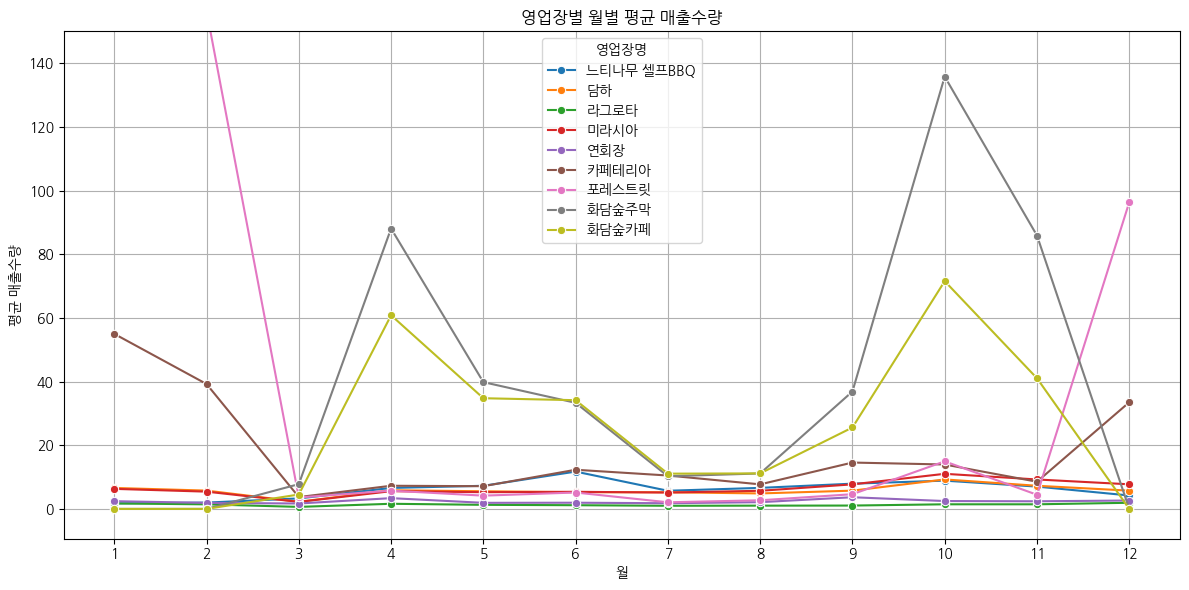

In [ ]:
monthly_avg = df.groupby(["영업장명", "월"])["매출수량"].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x="월", y="매출수량", hue="영업장명", marker="o")

plt.title("영업장별 월별 평균 매출수량")
plt.xlabel("월")
plt.ylabel("평균 매출수량")
plt.xticks(range(1, 13))  # 1~12월
plt.grid(True)
plt.ylim(top=150)
plt.tight_layout()
plt.show()

In [1]:
df.head()

NameError: name 'df' is not defined

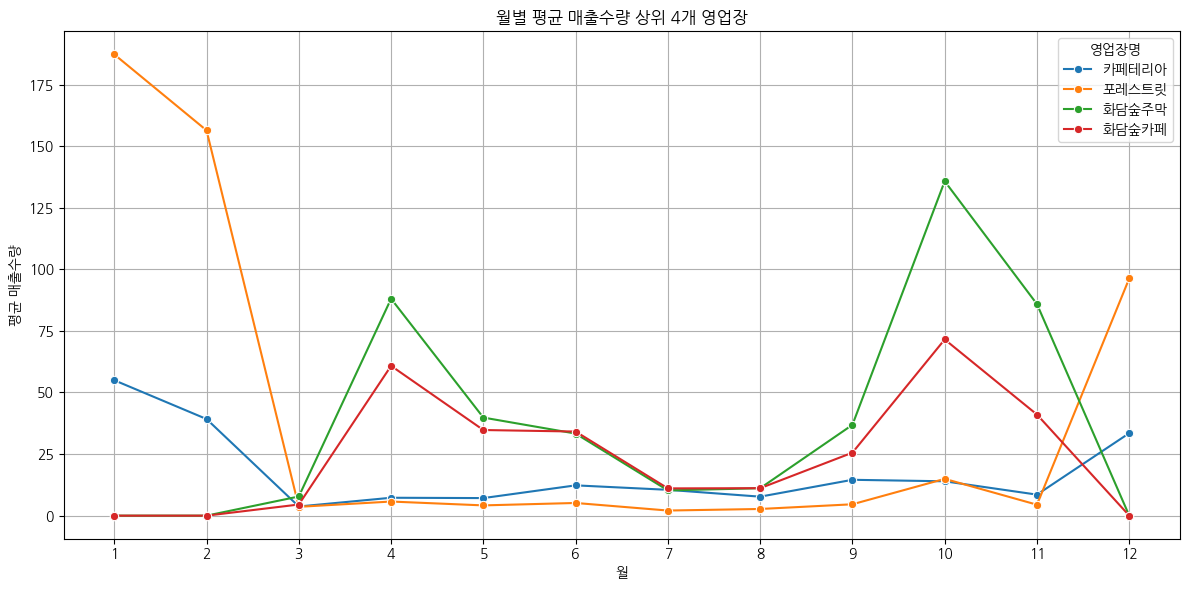

In [ ]:
monthly = df.groupby(["영업장명", "월"])["매출수량"].mean().reset_index()

top5_stores = (
    monthly.groupby("영업장명")["매출수량"]
    .mean()
    .sort_values(ascending=False)
    .head(4)
    .index
)

# 4. top5 영업장 데이터 필터링
top5_data = monthly[monthly["영업장명"].isin(top5_stores)]

# 5. 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=top5_data, x="월", y="매출수량", hue="영업장명", marker="o")

plt.title("월별 평균 매출수량 상위 4개 영업장")
plt.xlabel("월")
plt.ylabel("평균 매출수량")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

월별 판매량에서     
화담숲 주막과 화담숲 카페는 유사한 패턴 존재    
포레스트릿과 카페테리아도 증감의 추이는 유사함

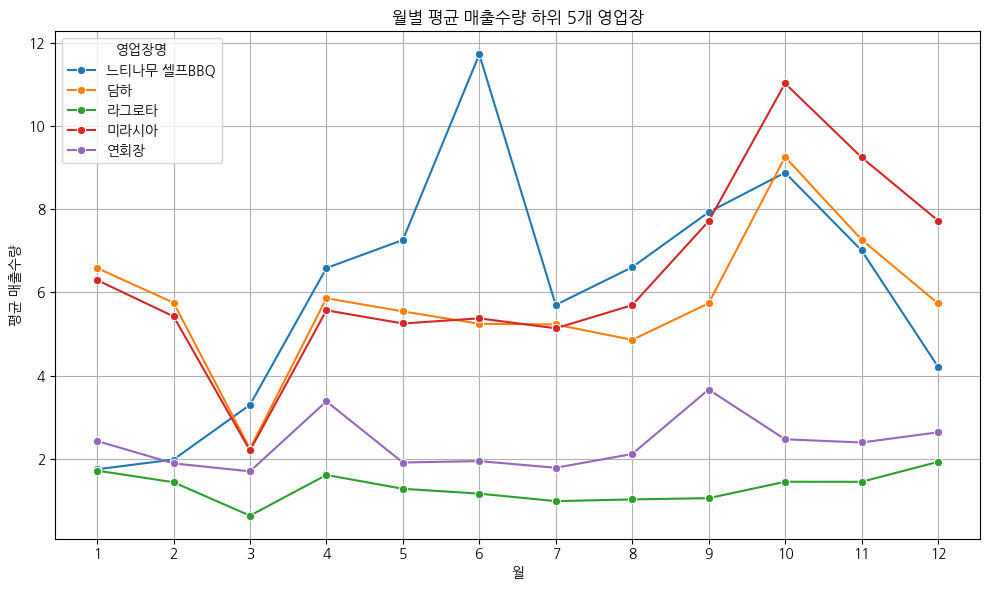

In [ ]:
monthly_avg = df.groupby(["영업장명", "월"])["매출수량"].mean().reset_index()

# 3. 전체 영업장별 평균 매출수량 계산 → 하위 5개 추출
bottom4_stores = (
    monthly_avg.groupby("영업장명")["매출수량"]
    .mean()
    .sort_values(ascending=True)
    .head(5)
    .index
)

# 4. 해당 영업장만 필터링
bottom4_data = monthly_avg[monthly_avg["영업장명"].isin(bottom4_stores)]

# 5. 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=bottom4_data, x="월", y="매출수량", hue="영업장명", marker="o")

plt.title("월별 평균 매출수량 하위 5개 영업장")
plt.xlabel("월")
plt.ylabel("평균 매출수량")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

월별 판매량에서     
담하와 미라시아는 유사한 패턴 발견      
연회장과 라그로타도 유사한 패턴 발견

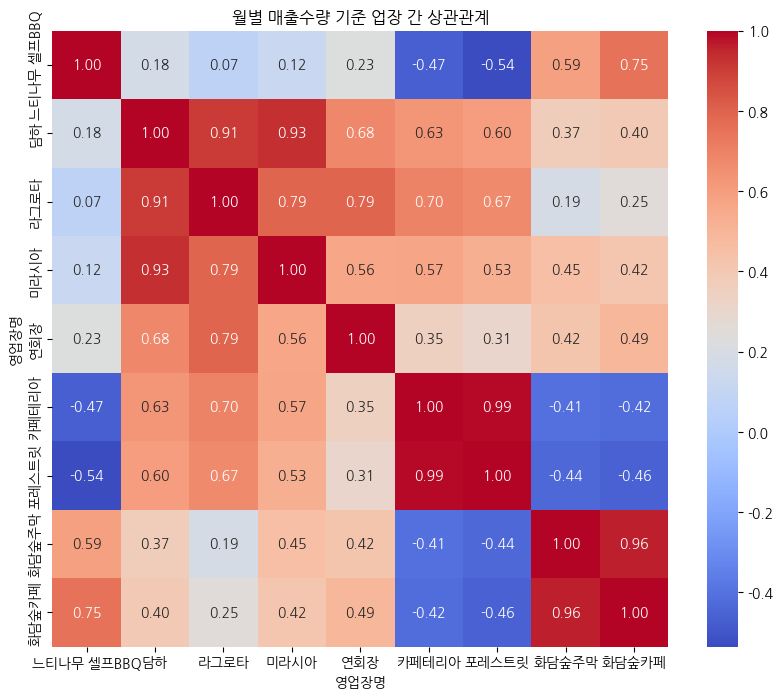

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 월별 매출수량 집계
monthly_sales = df.groupby(['영업장명', '월'])['매출수량'].sum().unstack().fillna(0)

# 2. 상관계수 계산
corr_matrix = monthly_sales.T.corr()

# 3. 관심 있는 업장만 추려서 보기
target_stores = df['영업장명'].unique()  # 또는 list(set(df['영업장명']))
corr_subset = corr_matrix.loc[target_stores, target_stores]

# 4. 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('월별 매출수량 기준 업장 간 상관관계')
plt.show()

In [ ]:
# 1. 클러스터 매핑 정의
cluster_map = {
    '담하': 'cluster_1',
    '미라시아': 'cluster_1',
    '라그로타': 'cluster_1',
    '연회장': 'cluster_1',
    '화담숲주막': 'cluster_2',
    '화담숲카페': 'cluster_2',
    '포레스트릿': 'cluster_3',
    '카페테리아': 'cluster_3'
}

df['업장_월별0'] = df['영업장명'].map(cluster_map).fillna('cluster_0')  # 클러스터에 없는 업장은 cluster_0으로 처리
df.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명,월,요일,메뉴클러스터,업장_요일패턴클러스터,주말여부,업장_월별0
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,6,0,0,1,cluster_0
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,0,0,0,0,cluster_0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,1,0,0,0,cluster_0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,2,0,0,0,cluster_0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,3,0,0,0,cluster_0


In [ ]:
# 분기를 수치형으로 변환
df['분기'] = df['영업일자'].dt.quarter
df['분기'].nunique()

4

<Axes: xlabel='분기'>

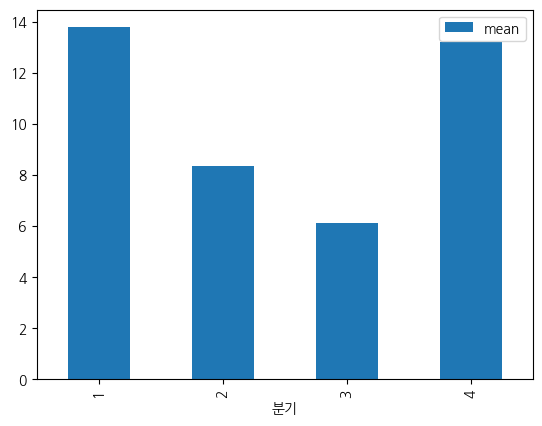

In [ ]:
df.groupby('분기')['매출수량'].agg(['mean']).plot(kind='bar')

봄과 겨울에 매출 수량이 많다

In [ ]:
from scipy.stats import pearsonr

# 분기별 집계 데이터 생성
seasonal_sales = (
    df.groupby(['영업장명', '분기', '메뉴명'])['매출수량']
    .sum()
    .reset_index()
)

# 상관계수 계산
result = []
result1= []
for store, store_df in seasonal_sales.groupby('영업장명'):
    for menu, menu_df in store_df.groupby('메뉴명'):
        if menu_df['분기'].nunique() >= 2:
            x = menu_df['분기'].astype(int)
            y = menu_df['매출수량']
            corr, _ = pearsonr(x, y)
            if corr>=0.5:
                result.append({'영업장명': store, '메뉴명': menu, '상관계수': corr})
            elif corr<=-0.5:
                result1.append({'영업장명': store, '메뉴명': menu, '상관계수': corr})


# 상관계수 높은 메뉴 상위 5개씩 추출
corr_df = pd.DataFrame(result)
top_corr_by_store = (
    corr_df.sort_values(['영업장명', '상관계수'], ascending=[True, False])
    .groupby('영업장명')
    .head(9).reset_index(drop=True)
)
corr_df1 = pd.DataFrame(result1)
# 음의 상관계수 상위 5개 메뉴 추출: 계절이 바뀔수록 매출이 뚜렷하게 감소하는 메뉴
bottom_corr_by_store = (
    corr_df.sort_values(['영업장명', '상관계수'], ascending=[True, True])
    .groupby('영업장명')
    .head(15).reset_index(drop=True)
)

display(top_corr_by_store)
display(bottom_corr_by_store)

,영업장명,메뉴명,상관계수
0,담하,명인안동소주,0.969502
1,담하,(단체) 은이버섯 갈비탕,0.696505
2,담하,담하 한우 불고기 정식,0.666750
3,담하,(정식) 된장찌개,0.642601
4,라그로타,그릴드 비프 샐러드,0.563740
5,미라시아,칠리 치즈 프라이,0.969452
6,미라시아,파스타면 추가(150g),0.896178
7,미라시아,스프라이트,0.866249
8,미라시아,버드와이저(무제한),0.843834
9,미라시아,코카콜라(제로),0.703095


,영업장명,메뉴명,상관계수
0,담하,(정식) 된장찌개,0.642601
1,담하,담하 한우 불고기 정식,0.666750
2,담하,(단체) 은이버섯 갈비탕,0.696505
3,담하,명인안동소주,0.969502
4,라그로타,그릴드 비프 샐러드,0.563740
5,미라시아,쉬림프 투움바 파스타,0.673378
6,미라시아,보일링 랍스타 플래터,0.701024
7,미라시아,코카콜라(제로),0.703095
8,미라시아,버드와이저(무제한),0.843834
9,미라시아,스프라이트,0.866249


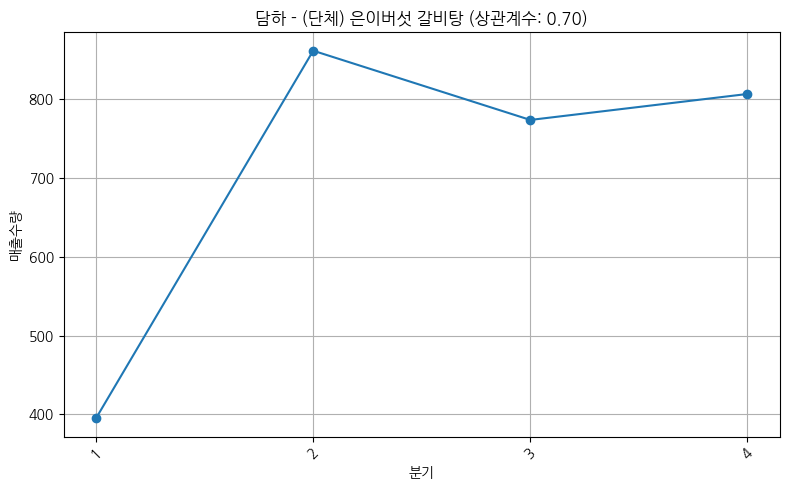

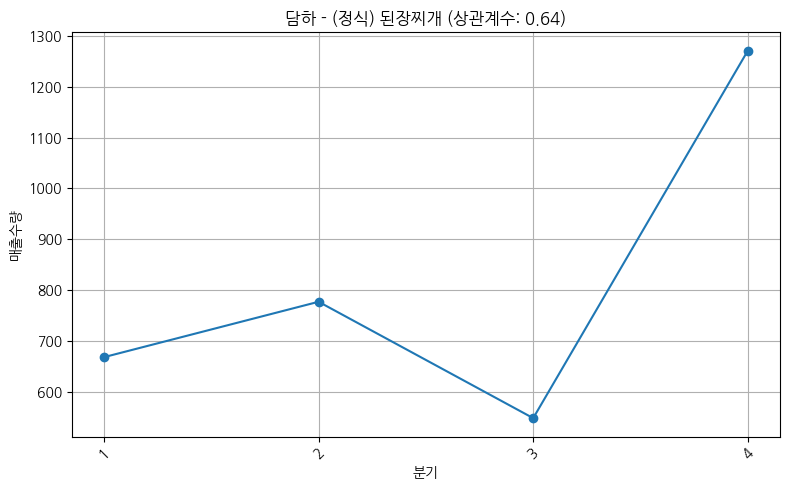

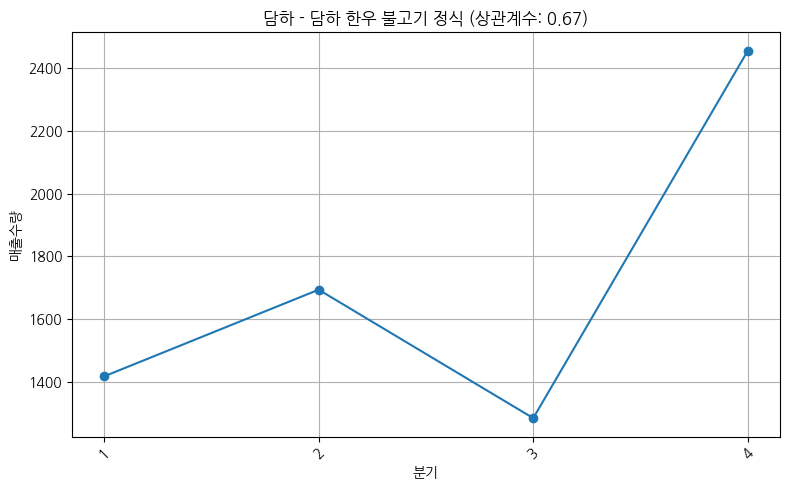

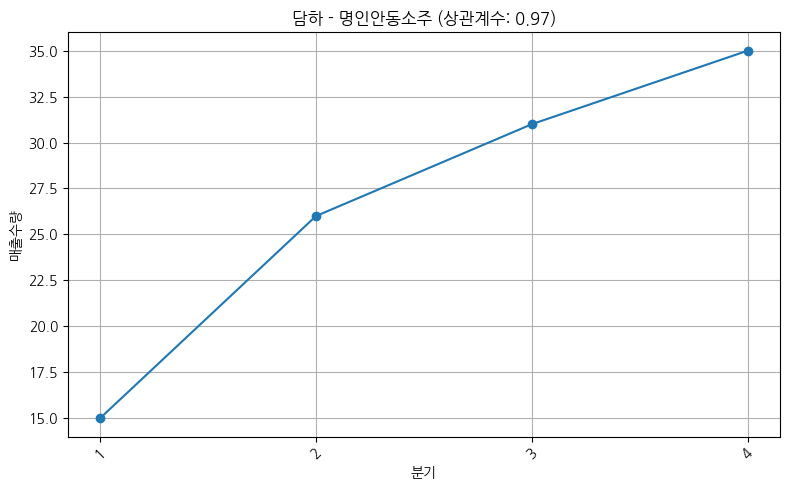

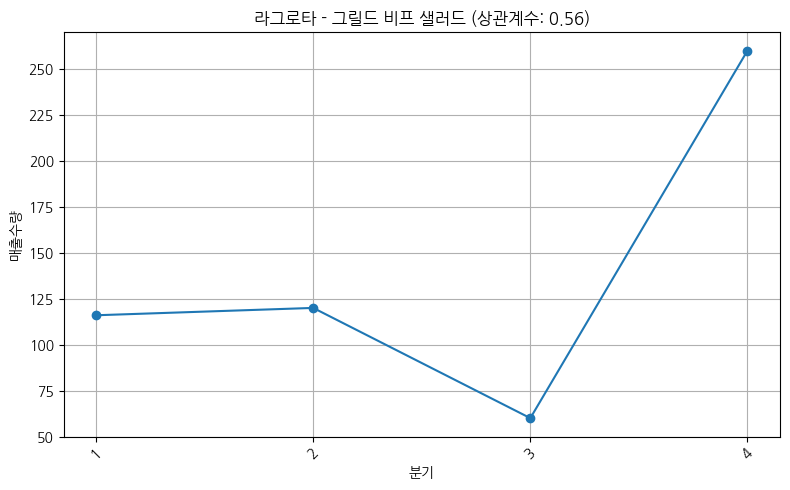

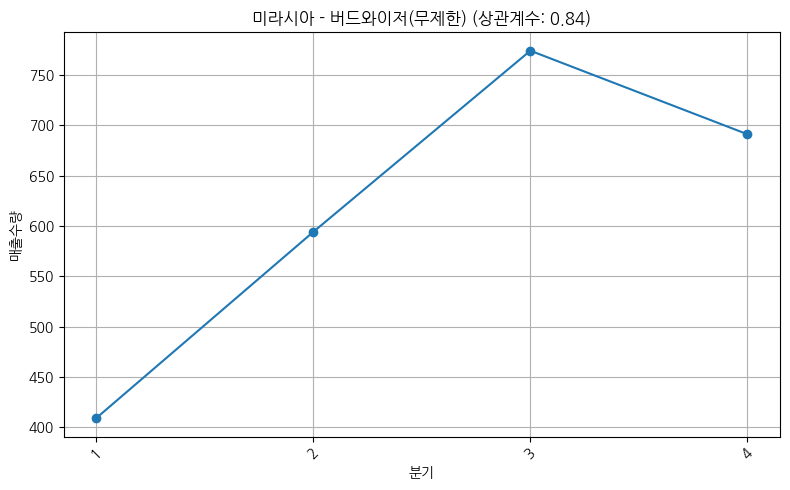

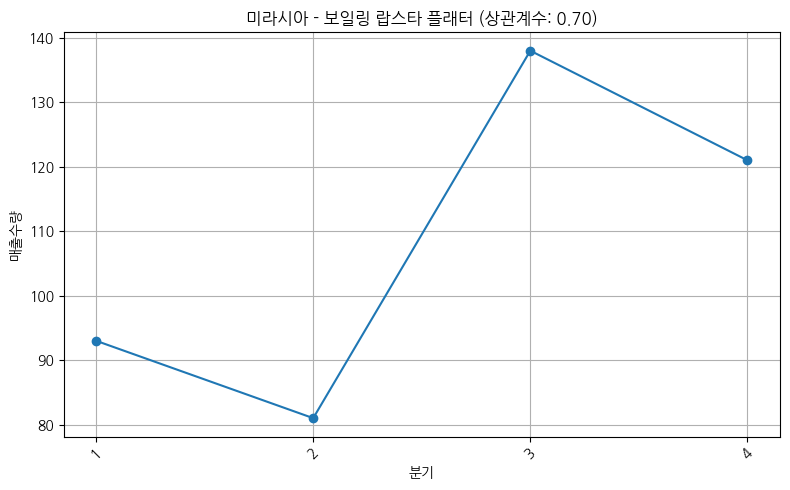

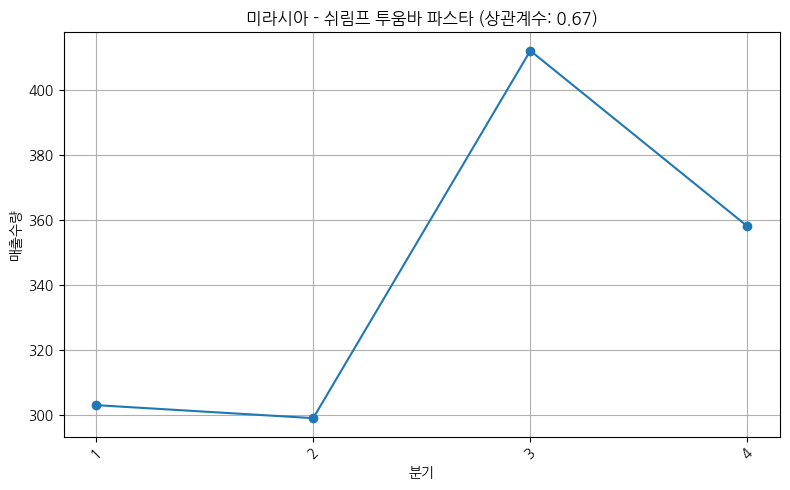

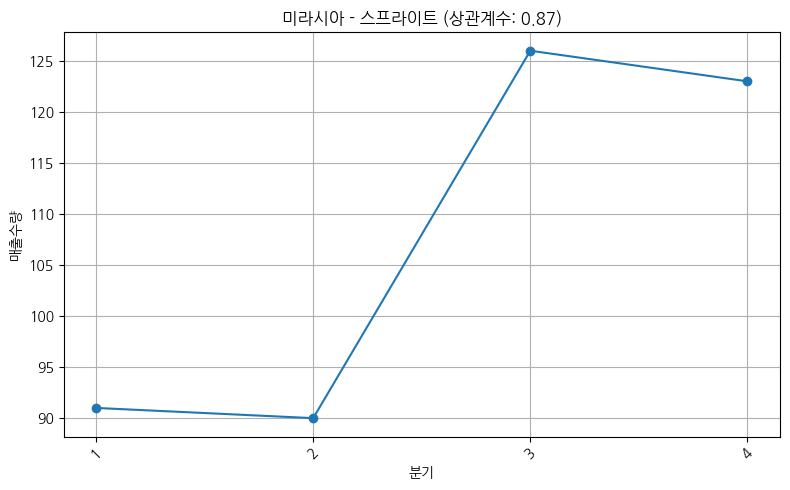

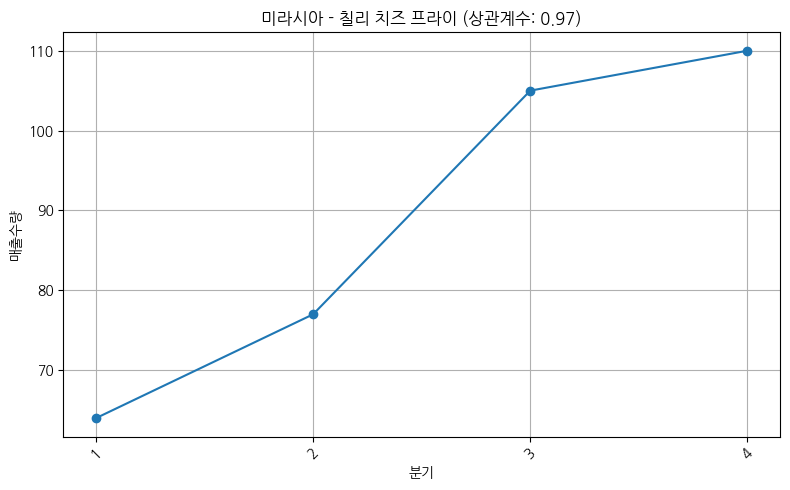

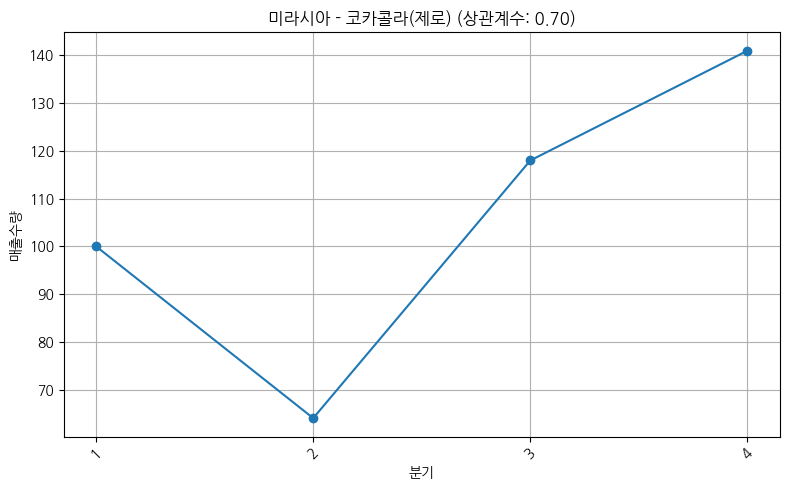

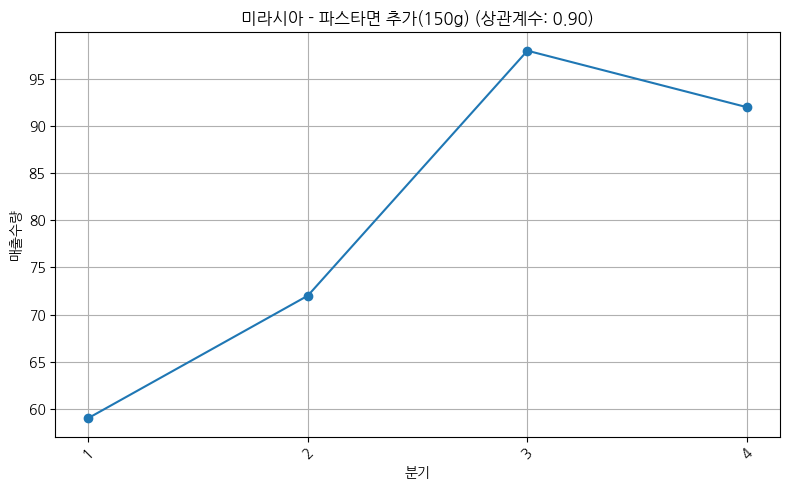

In [ ]:
for _, row in corr_df.iterrows():
    temp = df[(df['영업장명'] == row['영업장명']) & (df['메뉴명'] == row['메뉴명'])].copy()

    # 분기를 문자열로 변환
    temp['분기_문자'] = temp['분기'].astype(str)

    temp_grouped = temp.groupby('분기_문자')['매출수량'].sum().sort_index()

    plt.figure(figsize=(8, 5))
    plt.plot(temp_grouped.index, temp_grouped.values, marker='o')
    plt.title(f"{row['영업장명']} - {row['메뉴명']} (상관계수: {row['상관계수']:.2f})")
    plt.xlabel('분기')
    plt.ylabel('매출수량')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# 실제로 매출이 발생한 분기의 수만 계산
menu_var = df[df['매출수량'] > 0].groupby('영업장명_메뉴명')['분기'].nunique()

# 2개의 분기에서만 팔린 메뉴들 = 계절성 매우 강하거나 한정된 메뉴
low_season_menus = menu_var[menu_var ==2].index
low_season_menus

Index(['미라시아_공깃밥', '카페테리아_복숭아 아이스티', '카페테리아_새우튀김 우동', '카페테리아_샷 추가',
       '카페테리아_아메리카노(HOT)', '카페테리아_아메리카노(ICE)', '카페테리아_진사골 설렁탕',
       '카페테리아_카페라떼(HOT)', '카페테리아_카페라떼(ICE)'],
      dtype='object', name='영업장명_메뉴명')

In [ ]:
# 실제로 매출이 발생한 분기의 수만 계산
menu_var = df[df['매출수량'] > 0].groupby('영업장명_메뉴명')['분기'].nunique()

# 1개의 분기에서만 팔린 메뉴들 = 계절성 매우 강하거나 한정된 메뉴
low_season_menus = menu_var[menu_var ==3].index
low_season_menus

Index(['느티나무 셀프BBQ_신라면', '느티나무 셀프BBQ_잔디그늘집 대여료 (12인석)',
       '느티나무 셀프BBQ_잔디그늘집 의자 추가', '담하_갑오징어 비빔밥', '담하_갱시기', '담하_꼬막 비빔밥',
       '라그로타_AUS (200g)', '라그로타_까르보나라', '라그로타_버섯 크림 리조또', '라그로타_한우 (200g)',
       '라그로타_해산물 토마토 스튜 파스타', '미라시아_콥 샐러드', '카페테리아_구슬아이스크림'],
      dtype='object', name='영업장명_메뉴명')

In [ ]:
from sklearn.cluster import KMeans

# 분기별 매출수량 평균 계산
pivot = df.groupby(['영업장명_메뉴명', '분기'])['매출수량'].mean().unstack().fillna(0)
diff_pivot = pivot.diff(axis=1).fillna(0)  # 분기 간 변화량
from sklearn.metrics import silhouette_score

best_k = 0
best_score = -1

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(diff_pivot)
    score = silhouette_score(diff_pivot, labels)
    print(f"클러스터 수: {k}, 실루엣 점수: {score:.4f}")

    if score > best_score:
        best_k = k
        best_score = score

print(f"✅ 최적의 클러스터 수: {best_k} (실루엣 점수 기준)")


클러스터 수: 2, 실루엣 점수: 0.8885
클러스터 수: 3, 실루엣 점수: 0.7023
클러스터 수: 4, 실루엣 점수: 0.7244
클러스터 수: 5, 실루엣 점수: 0.7478
클러스터 수: 6, 실루엣 점수: 0.7533
클러스터 수: 7, 실루엣 점수: 0.7216
클러스터 수: 8, 실루엣 점수: 0.7090
클러스터 수: 9, 실루엣 점수: 0.7124
클러스터 수: 10, 실루엣 점수: 0.7136
✅ 최적의 클러스터 수: 2 (실루엣 점수 기준)


In [ ]:
from sklearn.cluster import KMeans

# ① 분기별 평균 매출수량
pivot = df.groupby(['영업장명_메뉴명', '분기'])['매출수량'].mean().unstack().fillna(0)

# ② 분기 간 변화량 계산 (분기1 → 분기2, 분기2 → 분기3, ...)
diff_pivot = pivot.diff(axis=1).fillna(0)

# ③ KMeans 클러스터링 (n_clusters=6)
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(diff_pivot)

# ④ 클러스터 정보 저장
cluster_info = pd.DataFrame({
    '영업장명_메뉴명': diff_pivot.index,
    '분기클러스터': cluster_labels
})
# 병합
df = df.merge(cluster_info, on='영업장명_메뉴명', how='left')

In [ ]:
df.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명,월,요일,메뉴클러스터,업장_요일패턴클러스터,주말여부,업장_월별0,분기,분기클러스터
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,6,0,0,1,cluster_0,1,0
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,0,0,0,0,cluster_0,1,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,1,0,0,0,cluster_0,1,0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,2,0,0,0,cluster_0,1,0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,3,0,0,0,cluster_0,1,0


### 메뉴별 시계열 패턴 확인

In [ ]:
from statsmodels.tsa.stattools import adfuller

# 저장용
stationary_menu_list = []        # 정상성 확보된 메뉴
non_stationary_menu_list = []    # 끝까지 정상성 안 된 메뉴
differenced_series_dict = {}     # 정상화된 시계열 저장

# 메뉴별 시계열 반복
for menu in df['영업장명_메뉴명'].unique():
    ts = df[df['영업장명_메뉴명'] == menu].groupby('영업일자')['매출수량'].sum().sort_index()

    # 시계열 길이 너무 짧으면 제외
    if len(ts.dropna()) < 10:
        continue

    # 0차: 원본
    if adfuller(ts.dropna())[1] < 0.05:
        stationary_menu_list.append(menu)
        differenced_series_dict[menu] = ts
        continue

    # 1차 차분
    ts_diff1 = ts.diff().dropna()
    if adfuller(ts_diff1)[1] < 0.05:
        stationary_menu_list.append(menu)
        differenced_series_dict[menu] = ts_diff1
        continue


    # 끝까지 정상성 확보 실패한 메뉴 저장
    non_stationary_menu_list.append(menu)

print(f"✅ 정상성 확보된 메뉴 수: {len(stationary_menu_list)}")
print(f"❌ 끝까지 정상성 확보 안 된 메뉴 수: {len(non_stationary_menu_list)}")
df['영업장명_메뉴명'].nunique()

✅ 정상성 확보된 메뉴 수: 193
❌ 끝까지 정상성 확보 안 된 메뉴 수: 0


193

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

white_noise_menus = []

for menu, ts in differenced_series_dict.items():
    lb_test = acorr_ljungbox(ts, lags=[10], return_df=True)
    p_value = lb_test['lb_pvalue'].values[0]

    if p_value >= 0.05:
        white_noise_menus.append(menu)

print(f"백색잡음 가능성 있는 메뉴 수: {len(white_noise_menus)}")
print(white_noise_menus)

백색잡음 가능성 있는 메뉴 수: 11
['담하_(단체) 공깃밥', '담하_룸 이용료', '라그로타_G-Charge(3)', '라그로타_Open Food', '라그로타_미션 서드 카베르네 쉬라', '라그로타_스프라이트', '라그로타_제로콜라', '라그로타_카스', '미라시아_BBQ 고기추가', '미라시아_글라스와인 (레드)', '미라시아_레인보우칵테일(알코올)']


백색 잡음인 메뉴는 예측 불가능한 경우임 그 외에는 자기 상관성을 가질 수 있음(예측 가능한 패턴 존재)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

acf_results = []
pacf_results = []

max_lag = 20
alpha = 0.05  # 신뢰구간 95%

for menu, ts in differenced_series_dict.items():
    try:
        # ACF 및 신뢰구간 계산
        acf_vals, acf_confint = acf(ts, nlags=max_lag, alpha=alpha)
        pacf_vals, pacf_confint = pacf(ts, nlags=max_lag, alpha=alpha, method='ywm')

        found_acf = False
        found_pacf = False

        for lag in range(1, max_lag + 1):
            # ACF
            acf_lower, acf_upper = acf_confint[lag]
            if acf_vals[lag] < acf_lower or acf_vals[lag] > acf_upper:
                acf_results.append({'영업장명_메뉴명': menu, '유의한_lag': lag, '값': acf_vals[lag], 'type': 'ACF'})
                found_acf = True

            # PACF
            pacf_lower, pacf_upper = pacf_confint[lag]
            if pacf_vals[lag] < pacf_lower or pacf_vals[lag] > pacf_upper:
                pacf_results.append({'영업장명_메뉴명': menu, '유의한_lag': lag, '값': pacf_vals[lag], 'type': 'PACF'})
                found_pacf = True

        # 유의한 lag가 하나도 없더라도 기록
        if not found_acf:
            acf_results.append({'영업장명_메뉴명': menu, '유의한_lag': None, '값': None, 'type': 'ACF'})
        if not found_pacf:
            pacf_results.append({'영업장명_메뉴명': menu, '유의한_lag': None, '값': None, 'type': 'PACF'})

    except Exception as e:
        print(f"[오류] {menu} 처리 중 문제 발생: {e}")


In [ ]:
acf_df = pd.DataFrame(acf_results)
pacf_df = pd.DataFrame(pacf_results)

print("ACF 유의한 lag 수:", acf_df['유의한_lag'].notna().sum())
print("PACF 유의한 lag 수:", pacf_df['유의한_lag'].notna().sum())

ACF 유의한 lag 수: 0
PACF 유의한 lag 수: 0


### 업장별 시계열 패턴 확인

In [ ]:
from statsmodels.tsa.stattools import adfuller

# 저장용
stationary_menu_list = []        # 정상성 확보된 메뉴
non_stationary_menu_list = []    # 끝까지 정상성 안 된 메뉴
differenced_series_dict = {}     # 정상화된 시계열 저장

# 메뉴별 시계열 반복
for menu in df['영업장명'].unique():
    ts = df[df['영업장명'] == menu].groupby('영업일자')['매출수량'].sum().sort_index()

    # 시계열 길이 너무 짧으면 제외
    if len(ts.dropna()) < 10:
        continue

    # 0차: 원본
    if adfuller(ts.dropna())[1] < 0.05:
        stationary_menu_list.append(menu)
        differenced_series_dict[menu] = ts
        continue

    # 1차 차분
    ts_diff1 = ts.diff().dropna()
    if adfuller(ts_diff1)[1] < 0.05:
        stationary_menu_list.append(menu)
        differenced_series_dict[menu] = ts_diff1
        continue


    # 끝까지 정상성 확보 실패한 메뉴 저장
    non_stationary_menu_list.append(menu)

print(f"✅ 정상성 확보된 메뉴 수: {len(stationary_menu_list)}")
print(f"❌ 끝까지 정상성 확보 안 된 메뉴 수: {len(non_stationary_menu_list)}")
from statsmodels.stats.diagnostic import acorr_ljungbox

white_noise_menus = []

for menu, ts in differenced_series_dict.items():
    lb_test = acorr_ljungbox(ts, lags=[10], return_df=True)
    p_value = lb_test['lb_pvalue'].values[0]

    if p_value >= 0.05:
        white_noise_menus.append(menu)

print(f"백색잡음 가능성 있는 메뉴 수: {len(white_noise_menus)}")
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
acf_results = []
pacf_results = []

max_lag = 20
alpha = 0.05  # 신뢰구간 95%

for menu, ts in differenced_series_dict.items():
    try:
        # ACF 및 신뢰구간 계산
        acf_vals, acf_confint = acf(ts, nlags=max_lag, alpha=alpha)
        pacf_vals, pacf_confint = pacf(ts, nlags=max_lag, alpha=alpha, method='ywm')

        found_acf = False
        found_pacf = False

        for lag in range(1, max_lag + 1):
            # ACF
            acf_lower, acf_upper = acf_confint[lag]
            if acf_vals[lag] < acf_lower or acf_vals[lag] > acf_upper:
                acf_results.append({'영업장명': menu, '유의한_lag': lag, '값': acf_vals[lag], 'type': 'ACF'})
                found_acf = True

            # PACF
            pacf_lower, pacf_upper = pacf_confint[lag]
            if pacf_vals[lag] < pacf_lower or pacf_vals[lag] > pacf_upper:
                pacf_results.append({'영업장명': menu, '유의한_lag': lag, '값': pacf_vals[lag], 'type': 'PACF'})
                found_pacf = True

        # 유의한 lag가 하나도 없더라도 기록
        if not found_acf:
            acf_results.append({'영업장명': menu, '유의한_lag': None, '값': None, 'type': 'ACF'})
        if not found_pacf:
            pacf_results.append({'영업장명': menu, '유의한_lag': None, '값': None, 'type': 'PACF'})

    except Exception as e:
        print(f"[오류] {menu} 처리 중 문제 발생: {e}")
acf_df = pd.DataFrame(acf_results)
pacf_df = pd.DataFrame(pacf_results)

print("ACF 유의한 lag 수:", acf_df['유의한_lag'].notna().sum())
print("PACF 유의한 lag 수:", pacf_df['유의한_lag'].notna().sum())

✅ 정상성 확보된 메뉴 수: 9
❌ 끝까지 정상성 확보 안 된 메뉴 수: 0
백색잡음 가능성 있는 메뉴 수: 0
ACF 유의한 lag 수: 0
PACF 유의한 lag 수: 0


###전체 시계열 패턴 확인

In [ ]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

# 전체 시계열 생성 (모든 메뉴 합산 기준 예시)
ts = df.groupby('영업일자')['매출수량'].sum().sort_index()

# ADF 테스트 (정상성 확인)
print("===== 📈 ADF Test (정상성) =====")
adf_result = adfuller(ts.dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("✅ 정상성 있음")
    ts_final = ts
else:
    # 1차 차분
    ts_diff = ts.diff().dropna()
    adf_result_diff = adfuller(ts_diff)
    print("\n===== 📈 ADF Test (1차 차분) =====")
    print(f"ADF Statistic: {adf_result_diff[0]}")
    print(f"p-value: {adf_result_diff[1]}")
    if adf_result_diff[1] < 0.05:
        print("✅ 1차 차분 후 정상성 확보됨")
        ts_final = ts_diff
    else:
        print("❌ 정상성 확보 실패")
        ts_final = ts_diff  # 그래도 계속 사용

# Ljung-Box 테스트 (백색잡음 여부)
print("\n===== 🔍 Ljung-Box Test (백색잡음 확인) =====")
lb_test = acorr_ljungbox(ts_final, lags=[10], return_df=True)
p_value = lb_test['lb_pvalue'].values[0]
print(f"Ljung-Box p-value: {p_value}")
if p_value >= 0.05:
    print("⚠️ 백색잡음 가능성 있음 (자기상관 없음)")
else:
    print("✅ 자기상관 있음 (모델링 가능성 있음)")

# ACF / PACF 분석
print("\n===== 🔍 ACF / PACF =====")
max_lag = 20
alpha = 0.05

acf_vals, acf_conf = acf(ts_final, nlags=max_lag, alpha=alpha)
pacf_vals, pacf_conf = pacf(ts_final, nlags=max_lag, alpha=alpha, method='ywm')

sig_acf_lags = []
sig_pacf_lags = []

for lag in range(1, max_lag + 1):
    acf_lower, acf_upper = acf_conf[lag]
    if acf_vals[lag] < acf_lower or acf_vals[lag] > acf_upper:
        sig_acf_lags.append(lag)

    pacf_lower, pacf_upper = pacf_conf[lag]
    if pacf_vals[lag] < pacf_lower or pacf_vals[lag] > pacf_upper:
        sig_pacf_lags.append(lag)

print(f"📌 유의한 ACF lag 수: {len(sig_acf_lags)} → {sig_acf_lags}")
print(f"📌 유의한 PACF lag 수: {len(sig_pacf_lags)} → {sig_pacf_lags}")


===== 📈 ADF Test (정상성) =====
ADF Statistic: -3.2523930662957308
p-value: 0.017145330142037386
✅ 정상성 있음

===== 🔍 Ljung-Box Test (백색잡음 확인) =====
Ljung-Box p-value: 0.0
✅ 자기상관 있음 (모델링 가능성 있음)

===== 🔍 ACF / PACF =====
📌 유의한 ACF lag 수: 0 → []
📌 유의한 PACF lag 수: 0 → []


유의한 lag의 수가 없음
데이터가 너무 짧아서 계절성 주기를 못 잡는 경우
**연간 계절성(예: 추석, 여름방학, 계절 등)**은 보통 1년 단위 이상 데이터를 요구함.  
28일 데이터를 가지고 7일을 예측할 것이기 때문에 lag 피쳐는 단독으로는 의미 없음

머신러닝 모델을 통해 다른 피쳐와의 조합에서 의미 있을 수 있기 때문에 1~7까지의 lag는 추가

In [ ]:
# lag 1부터 7까지 생성
for i in range(1, 8):
    df[f'lag{i}'] = df.groupby('영업장명_메뉴명')['매출수량'].shift(i)
df.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명,월,요일,메뉴클러스터,업장_요일패턴클러스터,주말여부,업장_월별0,분기,분기클러스터,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,6,0,0,1,cluster_0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,0,0,0,0,cluster_0,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,1,0,0,0,cluster_0,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,2,0,0,0,cluster_0,1,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,3,0,0,0,cluster_0,1,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
df = df.sort_values(by=['영업장명_메뉴명', '영업일자'])

#최근 7일 평균/표준편차
df['rolling_mean_7'] = (
    df.groupby('영업장명_메뉴명')['매출수량']
      .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())
)
df['rolling_std_7'] = (
    df.groupby('영업장명_메뉴명')['매출수량']
      .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).std())
)


In [ ]:
df.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명,월,요일,메뉴클러스터,업장_요일패턴클러스터,주말여부,...,분기클러스터,lag1,lag2,lag3,lag4,lag5,lag6,lag7,rolling_mean_7,rolling_std_7
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,6,0,0,1,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,0,0,0,0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,1,0,0,0,...,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,2,0,0,0,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,3,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0


In [ ]:
!pip install --force-reinstall korean-lunar-calendar==0.2.1

  Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl.metadata (2.9 kB)
Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB)
  Attempting uninstall: korean-lunar-calendar
    Found existing installation: korean-lunar-calendar 0.2.1
    Uninstalling korean-lunar-calendar-0.2.1:
      Successfully uninstalled korean-lunar-calendar-0.2.1


In [ ]:
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import date, timedelta
import pandas as pd

def get_lunar_holiday_range(year, lunar_month, lunar_day, days=3):
    cal = KoreanLunarCalendar()
    cal.setLunarDate(year, lunar_month, lunar_day, False)
    main_day = date.fromisoformat(cal.SolarIsoFormat())
    return [(main_day + timedelta(days=i - 1)) for i in range(days)]

def get_all_korean_holidays(start_year=2023, end_year=2025):
    holiday_dates = []

    for year in range(start_year, end_year + 1):
        # 고정 양력 공휴일
        fixed = [
            date(year, 1, 1),   # 신정
            date(year, 3, 1),   # 삼일절
            date(year, 5, 5),   # 어린이날
            date(year, 6, 6),   # 현충일
            date(year, 8, 15),  # 광복절
            date(year, 10, 3),  # 개천절
            date(year, 10, 9),  # 한글날
            date(year, 12, 25)  # 성탄절
        ]
        holiday_dates.extend(fixed)

        # 설날 (음력 1월 1일 기준 -1, 0, +1)
        holiday_dates.extend(get_lunar_holiday_range(year, 1, 1))

        # 추석 (음력 8월 15일 기준 -1, 0, +1)
        holiday_dates.extend(get_lunar_holiday_range(year, 8, 15))

        # 부처님오신날 (음력 4월 8일, 하루)
        cal = KoreanLunarCalendar()
        cal.setLunarDate(year, 4, 8, False)
        buddha_day = date.fromisoformat(cal.SolarIsoFormat())
        holiday_dates.append(buddha_day)

    # 중복 제거 및 정렬
    holiday_dates = sorted(set(holiday_dates))
    return pd.to_datetime(holiday_dates)


start_year = df['영업일자'].dt.year.min()
end_year = df['영업일자'].dt.year.max()

holidays = get_all_korean_holidays(start_year, end_year)

df['영업일자'] = pd.to_datetime(df['영업일자'])
df['공휴일여부'] = df['영업일자'].isin(holidays).astype(int) #1일 때 공휴일
df.head()

,영업일자,영업장명_메뉴명,매출수량,영업장명,메뉴명,월,요일,메뉴클러스터,업장_요일패턴클러스터,주말여부,...,lag1,lag2,lag3,lag4,lag5,lag6,lag7,rolling_mean_7,rolling_std_7,공휴일여부
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,6,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,1,0,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,2,0,0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,1,3,0,0,0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0


<Axes: xlabel='공휴일여부'>

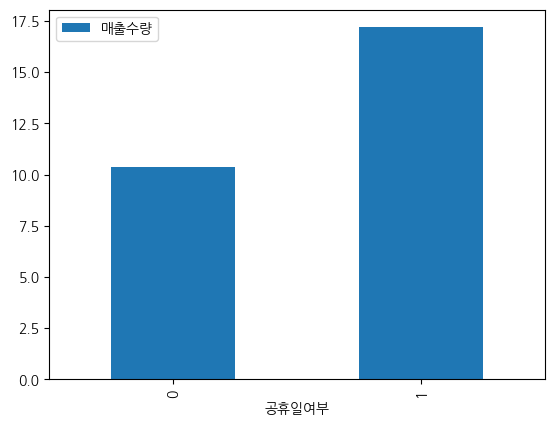

In [ ]:
holidays_df=df.groupby('공휴일여부')['매출수량'].mean().reset_index()
holidays_df.plot(x='공휴일여부',y='매출수량',kind='bar')

공휴일일 때 매출 수량이 많음

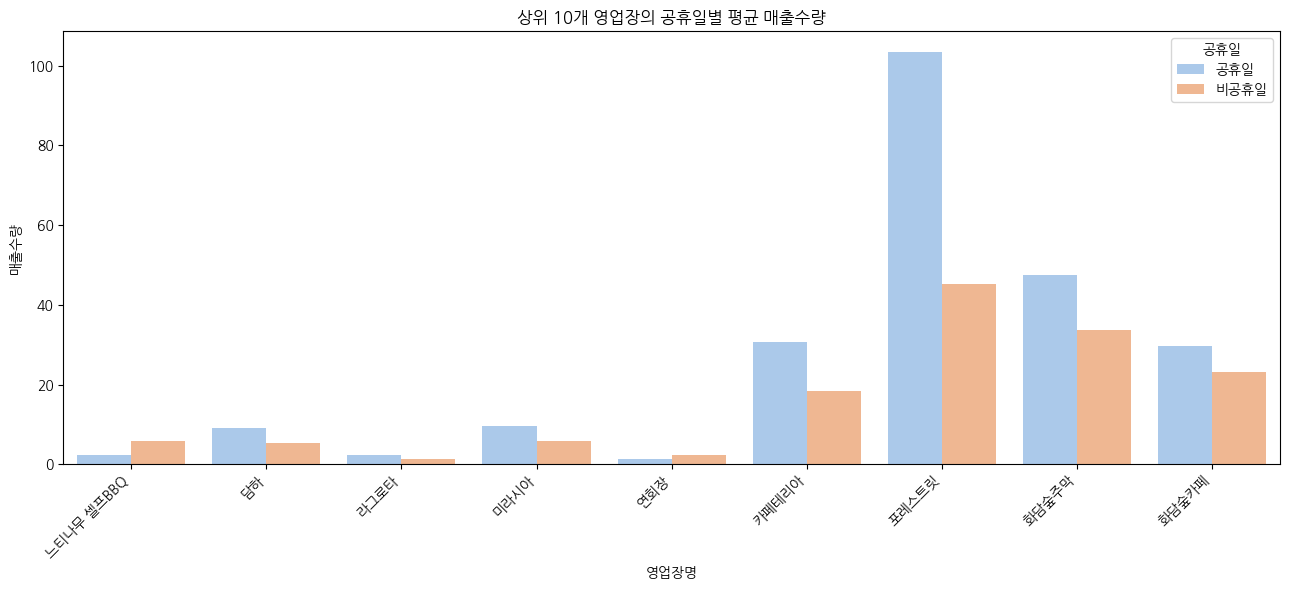

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 영업장 기준 매출 합산 → 상위 10개 영업장
top10_stores = (
    df.groupby('영업장명')['매출수량']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 2. 해당 영업장만 필터링
df_top10 = df[df['영업장명'].isin(top10_stores)].copy()

# 3. 공휴일 여부 텍스트 처리
df_top10['공휴일'] = df_top10['공휴일여부'].map({0: '비공휴일', 1: '공휴일'})

# 4. 평균 매출 계산 (영업장명 + 공휴일 여부)
avg_sales_top10 = (
    df_top10.groupby(['영업장명', '공휴일'])['매출수량']
    .mean()
    .reset_index()
)

# 5. 시각화
plt.figure(figsize=(13, 6))
sns.barplot(data=avg_sales_top10, x='영업장명', y='매출수량', hue='공휴일', palette='pastel')
plt.title('상위 10개 영업장의 공휴일별 평균 매출수량')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


느티나무 셀프 bbq와 연회장을 제외하고는 공휴일일 때 매출 수량이 높음 이는 주말 여부와 유사한 패턴으로 나타남

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102676 entries, 0 to 102675
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   영업일자            102676 non-null  datetime64[ns]
 1   영업장명_메뉴명        102676 non-null  object        
 2   매출수량            102676 non-null  int64         
 3   영업장명            102676 non-null  object        
 4   메뉴명             102676 non-null  object        
 5   월               102676 non-null  int32         
 6   요일              102676 non-null  int32         
 7   메뉴클러스터          102676 non-null  int64         
 8   업장_요일패턴클러스터     102676 non-null  category      
 9   주말여부            102676 non-null  int64         
 10  업장_월별0          102676 non-null  object        
 11  분기              102676 non-null  int32         
 12  분기클러스터          102676 non-null  int32         
 13  lag1            102483 non-null  float64       
 14  lag2            102290 non-null  flo